In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import (
    recall_score, precision_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, precision_recall_curve,
    average_precision_score, roc_curve
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# MLflow imports
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
# import mlflow.catboost  # Uncomment if using CatBoost

# Global settings
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# MLflow Setup
# Set experiment name - all runs will be grouped under this experiment
EXPERIMENT_NAME = "defasagem_prediction"
mlflow.set_experiment(EXPERIMENT_NAME)

print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment: {EXPERIMENT_NAME}")

MLflow tracking URI: http://localhost:5000
Experiment: defasagem_prediction


In [2]:
df = pd.read_csv('../data/processed/students_feature_engineering.csv')
df.head()

,ipv,ips,iaa,ieg,nº_av,ida,defasagem,media
0,7.278,5.6,8.3,4.1,4.0,4.0,1,4.896857
1,6.778,6.3,8.8,5.2,4.0,6.8,0,5.411143
2,7.556,5.6,0.0,7.9,4.0,5.6,0,4.379429
3,5.278,5.6,8.8,4.5,4.0,5.0,0,4.739714
4,7.389,5.6,7.9,8.6,4.0,5.2,0,5.527000


In [3]:
# Padroniza nome da coluna problemática
if "nº_av" in df.columns:
    df = df.rename(columns={"nº_av": "no_av"})

# Separate features and target
# Features: ipv, ips, iaa, ieg, no_av, ida, media
# Target: defasagem (0 or 1)

X = df[['ipv', 'ips', 'iaa', 'ieg', 'no_av', 'ida', 'media']].copy()
y = df['defasagem'].copy()

# Check class balance
print("Target class distribution:")
print(y.value_counts(normalize=True))
print(f"\nTotal samples: {len(y)}")


Target class distribution:
defasagem
1    0.590158
0    0.409842
Name: proportion, dtype: float64

Total samples: 2845


In [4]:
# Stratified split: 70% train, 15% val, 15% test
# First split: 85% train+val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=RANDOM_STATE
)

# Second split: 70% train, 15% val (from the 85% remaining)
# 0.1765 * 0.85 ≈ 0.15
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=RANDOM_STATE
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")
print(f"\nTrain distribution:\n{y_train.value_counts(normalize=True)}")
print(f"\nVal distribution:\n{y_val.value_counts(normalize=True)}")
print(f"\nTest distribution:\n{y_test.value_counts(normalize=True)}")

Train: 1991 | Val: 427 | Test: 427

Train distribution:
defasagem
1    0.590156
0    0.409844
Name: proportion, dtype: float64

Val distribution:
defasagem
1    0.590164
0    0.409836
Name: proportion, dtype: float64

Test distribution:
defasagem
1    0.590164
0    0.409836
Name: proportion, dtype: float64


In [5]:
# Log dataset split information to MLflow
# This creates a parent run for dataset information
with mlflow.start_run(run_name="dataset_info"):
    # Log split sizes
    mlflow.log_param("total_samples", len(df))
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("val_size", len(X_val))
    mlflow.log_param("test_size", len(X_test))
    mlflow.log_param("train_ratio", len(X_train) / len(df))
    mlflow.log_param("val_ratio", len(X_val) / len(df))
    mlflow.log_param("test_ratio", len(X_test) / len(df))
    
    # Log feature names
    mlflow.log_param("features", ", ".join(X.columns.tolist()))
    mlflow.log_param("n_features", len(X.columns))
    mlflow.log_param("target", "defasagem")
    
    # Log class distribution
    mlflow.log_metric("class_0_total", int((y == 0).sum()))
    mlflow.log_metric("class_1_total", int((y == 1).sum()))
    mlflow.log_metric("class_imbalance_ratio", float((y == 0).sum() / (y == 1).sum()))
    
    # Log train distribution
    mlflow.log_metric("class_0_train", int((y_train == 0).sum()))
    mlflow.log_metric("class_1_train", int((y_train == 1).sum()))
    
    # Log val distribution
    mlflow.log_metric("class_0_val", int((y_val == 0).sum()))
    mlflow.log_metric("class_1_val", int((y_val == 1).sum()))
    
    # Log test distribution
    mlflow.log_metric("class_0_test", int((y_test == 0).sum()))
    mlflow.log_metric("class_1_test", int((y_test == 1).sum()))
    
    mlflow.log_param("random_state", RANDOM_STATE)

print("Dataset information logged to MLflow")

🏃 View run dataset_info at: http://localhost:5000/#/experiments/1/runs/8302855fd802426a9c6e5051cb9df9d0
🧪 View experiment at: http://localhost:5000/#/experiments/1
Dataset information logged to MLflow


In [6]:
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name, log_to_mlflow=True):
    """
    Train model and evaluate on validation set
    Optionally logs to MLflow
    
    Args:
        model: sklearn-compatible model
        X_train, y_train: training data
        X_val, y_val: validation data
        model_name: string identifier for the model
        log_to_mlflow: whether to log results to MLflow
    
    Returns:
        metrics: dict with model performance metrics
        model: trained model object
    """
    
    # Start MLflow run if logging is enabled
    if log_to_mlflow:
        mlflow.start_run(run_name=model_name)
        
        # Log model parameters
        mlflow.log_params(model.get_params())
        
        # Log dataset information
        mlflow.log_param("train_samples", len(X_train))
        mlflow.log_param("val_samples", len(X_val))
        mlflow.log_param("n_features", X_train.shape[1])
        mlflow.log_param("class_0_train", int((y_train == 0).sum()))
        mlflow.log_param("class_1_train", int((y_train == 1).sum()))
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]  # Probability of class 1
    
    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Recall': recall_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred),
        'F1': f1_score(y_val, y_pred),
        'ROC-AUC': roc_auc_score(y_val, y_proba),
        'PR-AUC': average_precision_score(y_val, y_proba)
    }
    
    # Log metrics to MLflow
    if log_to_mlflow:
        mlflow.log_metric("recall", metrics['Recall'])
        mlflow.log_metric("precision", metrics['Precision'])
        mlflow.log_metric("f1", metrics['F1'])
        mlflow.log_metric("roc_auc", metrics['ROC-AUC'])
        mlflow.log_metric("pr_auc", metrics['PR-AUC'])
    
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    
    # Log confusion matrix components
    if log_to_mlflow:
        tn, fp, fn, tp = cm.ravel()
        mlflow.log_metric("true_negatives", int(tn))
        mlflow.log_metric("false_positives", int(fp))
        mlflow.log_metric("false_negatives", int(fn))
        mlflow.log_metric("true_positives", int(tp))
    
    # Visualizations
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'{model_name} - Confusion Matrix')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
    
    # Plot 2: Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_val, y_proba)
    axes[1].plot(recall, precision, marker='.')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title(f'{model_name} - PR Curve (AUC={metrics["PR-AUC"]:.3f})')
    axes[1].grid(True)
    
    plt.tight_layout()
    
    # Save and log figure to MLflow
    if log_to_mlflow:
        fig_path = f"{model_name.replace(' ', '_')}_plots.png"
        plt.savefig(fig_path)
        mlflow.log_artifact(fig_path)
        plt.show()
        
        # Log model to MLflow
        # Automatically detects model type and logs appropriately
        if 'XGBoost' in model_name:
            mlflow.xgboost.log_model(model, "model")
        elif 'LightGBM' in model_name:
            mlflow.lightgbm.log_model(model, "model")
        # elif 'CatBoost' in model_name:
        #     mlflow.catboost.log_model(model, "model")
        else:
            mlflow.sklearn.log_model(model, "model")
        
        # End MLflow run
        mlflow.end_run()
    else:
        plt.show()
    
    # Print classification report
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(y_val, y_pred))
    
    return metrics, model

In [7]:
def cross_val_metrics(model, X, y, cv=5, log_to_mlflow=False):
    """
    Perform stratified k-fold cross-validation
    Optionally logs CV metrics to current MLflow run
    
    Args:
        model: sklearn-compatible model
        X, y: training data
        cv: number of folds
        log_to_mlflow: whether to log to active MLflow run
    
    Returns:
        results: dict with mean ± std for each metric
    """
    
    # Stratified K-Fold to maintain class proportions
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    
    # Define scoring metrics
    scoring = {
        'recall': 'recall',
        'precision': 'precision',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    }
    
    # Execute cross-validation
    cv_results = cross_validate(
        model, X, y, cv=skf, scoring=scoring, return_train_score=False
    )
    
    # Calculate mean and std
    recall_mean = cv_results['test_recall'].mean()
    recall_std = cv_results['test_recall'].std()
    precision_mean = cv_results['test_precision'].mean()
    precision_std = cv_results['test_precision'].std()
    f1_mean = cv_results['test_f1'].mean()
    f1_std = cv_results['test_f1'].std()
    roc_auc_mean = cv_results['test_roc_auc'].mean()
    roc_auc_std = cv_results['test_roc_auc'].std()
    
    # Log to MLflow if active run exists
    if log_to_mlflow and mlflow.active_run():
        mlflow.log_metric("cv_recall_mean", recall_mean)
        mlflow.log_metric("cv_recall_std", recall_std)
        mlflow.log_metric("cv_precision_mean", precision_mean)
        mlflow.log_metric("cv_precision_std", precision_std)
        mlflow.log_metric("cv_f1_mean", f1_mean)
        mlflow.log_metric("cv_f1_std", f1_std)
        mlflow.log_metric("cv_roc_auc_mean", roc_auc_mean)
        mlflow.log_metric("cv_roc_auc_std", roc_auc_std)
    
    # Format results as mean ± std
    results = {
        'CV Recall': f"{recall_mean:.3f} ± {recall_std:.3f}",
        'CV Precision': f"{precision_mean:.3f} ± {precision_std:.3f}",
        'CV F1': f"{f1_mean:.3f} ± {f1_std:.3f}",
        'CV ROC-AUC': f"{roc_auc_mean:.3f} ± {roc_auc_std:.3f}"
    }
    
    return results

BASELINE: DummyClassifier (Stratified)


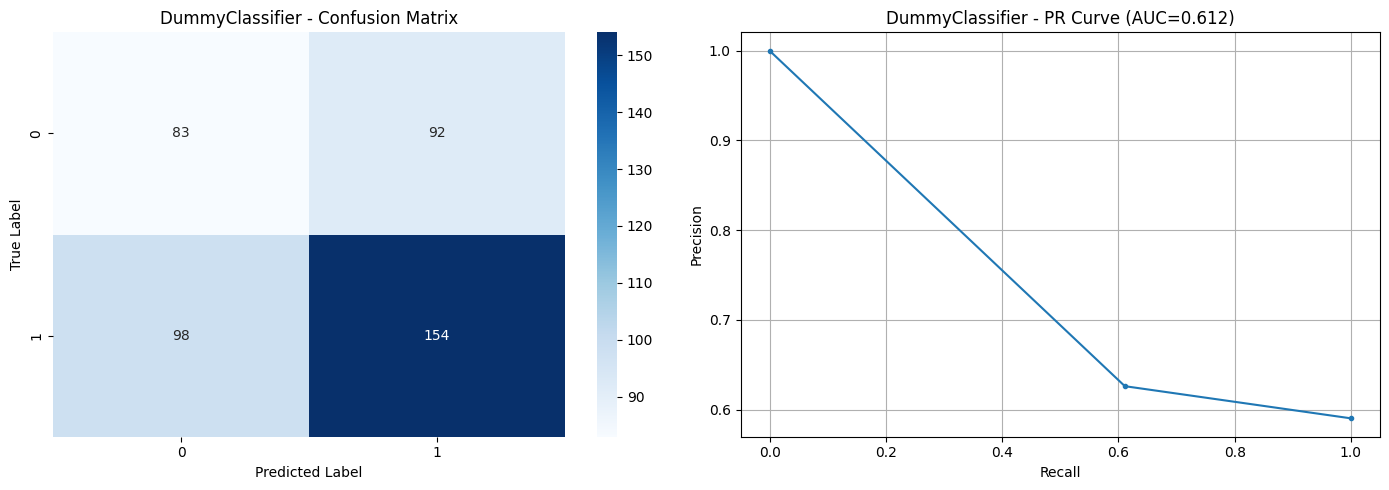

2026/02/12 22:16:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run DummyClassifier at: http://localhost:5000/#/experiments/1/runs/ee55caf47cab4e398a788d2ca7d1afda
🧪 View experiment at: http://localhost:5000/#/experiments/1

DummyClassifier - Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.47      0.47       175
           1       0.63      0.61      0.62       252

    accuracy                           0.56       427
   macro avg       0.54      0.54      0.54       427
weighted avg       0.56      0.56      0.56       427


Cross-Validation Metrics:
CV Recall: 0.566 ± 0.019
CV Precision: 0.578 ± 0.020
CV F1: 0.572 ± 0.020
CV ROC-AUC: 0.486 ± 0.024


In [8]:
# Baseline 1: DummyClassifier (Stratified)
# This model randomly predicts classes according to training set distribution
# Serves as minimum performance threshold
print("="*60)
print("BASELINE: DummyClassifier (Stratified)")
print("="*60)

dummy = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)

# Evaluate and log to MLflow
dummy_metrics, dummy_model = evaluate_model(
    dummy, X_train, y_train, X_val, y_val, 'DummyClassifier', log_to_mlflow=True
)

# Cross-validation (no need to log, already in main run)
dummy_cv = cross_val_metrics(dummy, X_train, y_train)
print("\nCross-Validation Metrics:")
for k, v in dummy_cv.items():
    print(f"{k}: {v}")


ALGORITHM: Random Forest


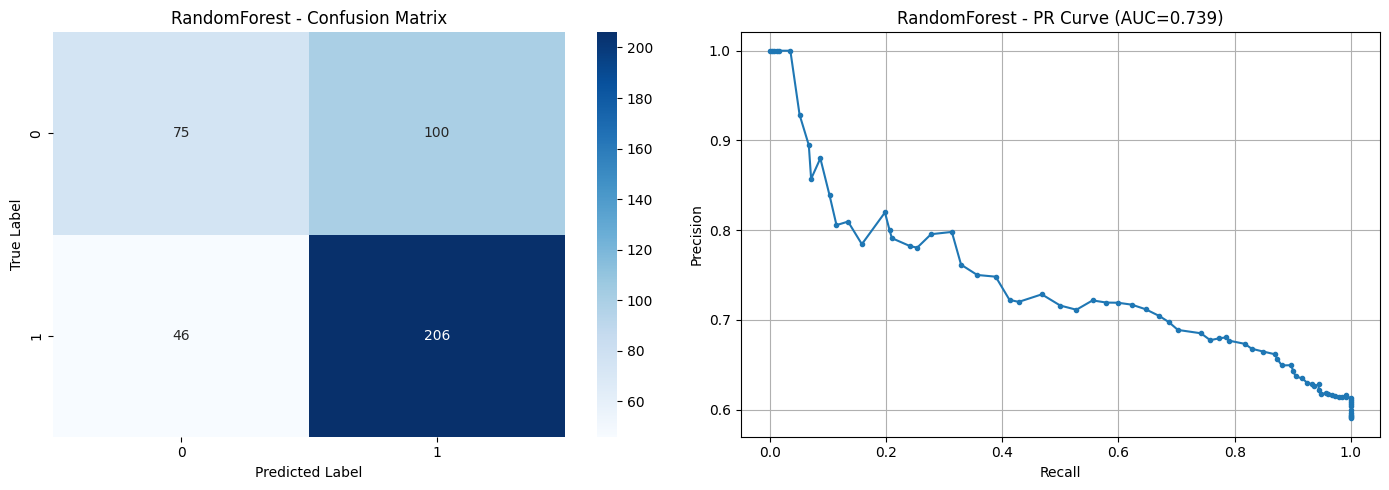

2026/02/12 22:16:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run RandomForest at: http://localhost:5000/#/experiments/1/runs/ef66419442f74598b04d4e790099bd6e
🧪 View experiment at: http://localhost:5000/#/experiments/1

RandomForest - Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.43      0.51       175
           1       0.67      0.82      0.74       252

    accuracy                           0.66       427
   macro avg       0.65      0.62      0.62       427
weighted avg       0.65      0.66      0.64       427


Cross-Validation Metrics:
CV Recall: 0.820 ± 0.031
CV Precision: 0.683 ± 0.015
CV F1: 0.745 ± 0.016
CV ROC-AUC: 0.724 ± 0.011


In [9]:
# Random Forest with default hyperparameters
# Ensemble of decision trees with bootstrap sampling
print("\n" + "="*60)
print("ALGORITHM: Random Forest")
print("="*60)

rf = RandomForestClassifier(
    n_estimators=100,          # Number of trees in the forest
    class_weight='balanced',   # Handle class imbalance
    random_state=RANDOM_STATE,
    n_jobs=-1                  # Use all CPU cores
)

# Evaluate and log to MLflow
rf_metrics, rf_model = evaluate_model(
    rf, X_train, y_train, X_val, y_val, 'RandomForest', log_to_mlflow=True
)

# Cross-validation
rf_cv = cross_val_metrics(rf, X_train, y_train)
print("\nCross-Validation Metrics:")
for k, v in rf_cv.items():
    print(f"{k}: {v}")


Feature Importance (Random Forest):
Feature  Importance
  media    0.208496
    ipv    0.190724
    ida    0.164855
    ieg    0.159058
    iaa    0.107848
    ips    0.105730
  no_av    0.063289


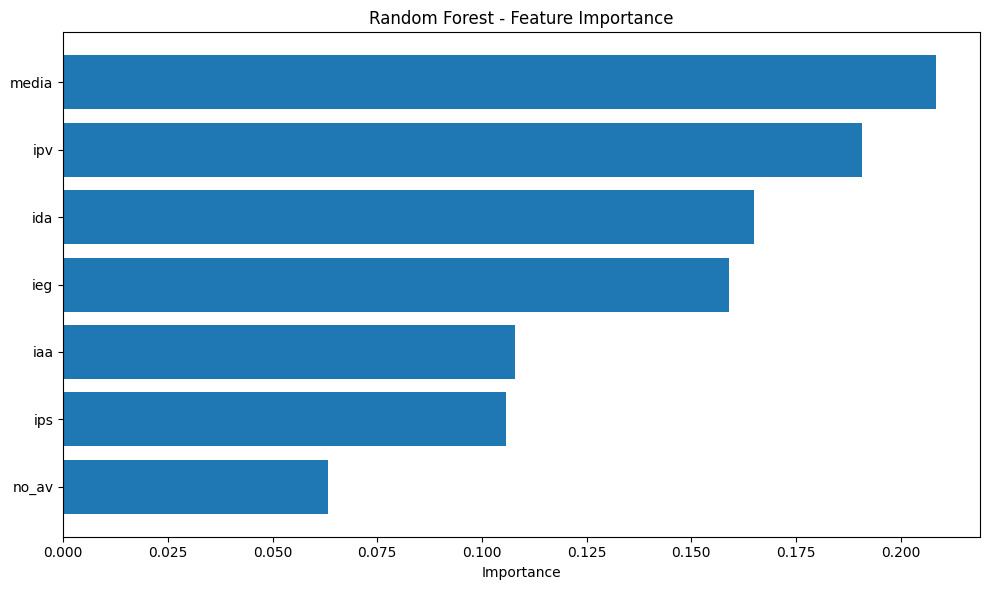

🏃 View run RandomForest_feature_importance at: http://localhost:5000/#/experiments/1/runs/da18a52a725e46328d62b150cb7a9056
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [10]:
# Feature Importance Analysis for Random Forest
# Shows which features contribute most to predictions
with mlflow.start_run(run_name="RandomForest_feature_importance"):
    feature_importance_rf = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance (Random Forest):")
    print(feature_importance_rf.to_string(index=False))
    
    # Log feature importances as metrics
    for idx, row in feature_importance_rf.iterrows():
        mlflow.log_metric(f"feat_imp_{row['Feature']}", row['Importance'])
    
    # Visualize and log
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_rf['Feature'], feature_importance_rf['Importance'])
    plt.xlabel('Importance')
    plt.title('Random Forest - Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    
    # Save and log to MLflow
    fig_path = "rf_feature_importance.png"
    plt.savefig(fig_path)
    mlflow.log_artifact(fig_path)
    plt.show()


ALGORITHM: XGBoost
Calculated scale_pos_weight: 0.69


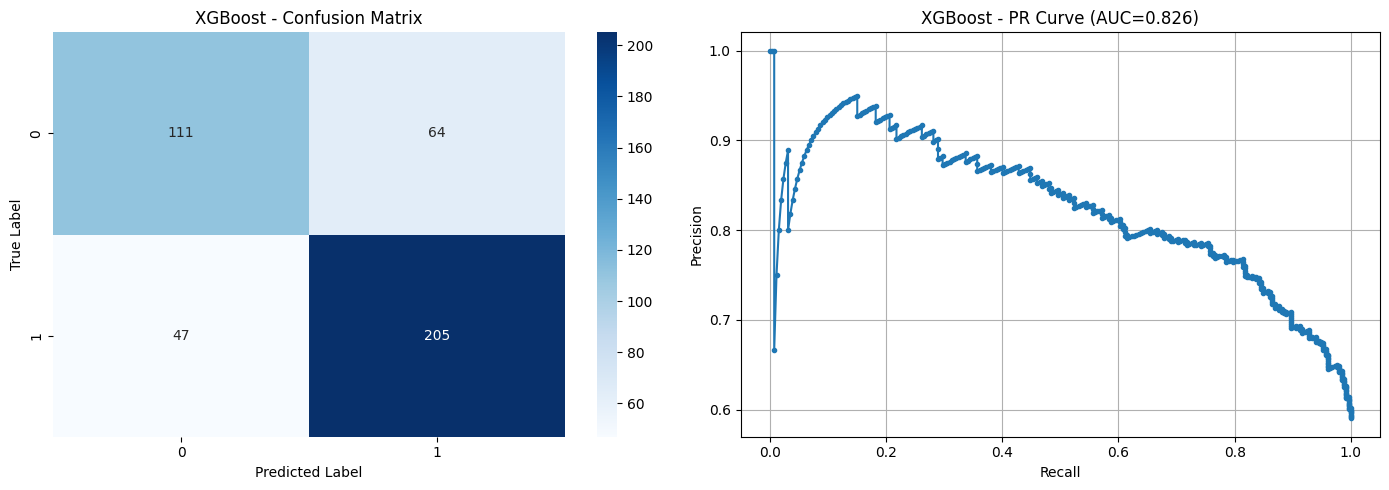

2026/02/12 22:16:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run XGBoost at: http://localhost:5000/#/experiments/1/runs/ebe05c9687074bae82e6200ce3a1c9a4
🧪 View experiment at: http://localhost:5000/#/experiments/1

XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.63      0.67       175
           1       0.76      0.81      0.79       252

    accuracy                           0.74       427
   macro avg       0.73      0.72      0.73       427
weighted avg       0.74      0.74      0.74       427


Cross-Validation Metrics:
CV Recall: 0.809 ± 0.022
CV Precision: 0.781 ± 0.024
CV F1: 0.794 ± 0.020
CV ROC-AUC: 0.825 ± 0.027


In [11]:
from xgboost import XGBClassifier

print("\n" + "="*60)
print("ALGORITHM: XGBoost")
print("="*60)

# Calculate scale_pos_weight for class imbalance
# Ratio of negative to positive samples
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

xgb = XGBClassifier(
    n_estimators=100,                  # Number of boosting rounds
    scale_pos_weight=scale_pos_weight, # Weight for positive class (handles imbalance)
    random_state=RANDOM_STATE,
    eval_metric='logloss',             # Evaluation metric during training
    use_label_encoder=False            # Avoid deprecation warning
)

# Evaluate and log to MLflow
xgb_metrics, xgb_model = evaluate_model(
    xgb, X_train, y_train, X_val, y_val, 'XGBoost', log_to_mlflow=True
)

# Cross-validation
xgb_cv = cross_val_metrics(xgb, X_train, y_train)
print("\nCross-Validation Metrics:")
for k, v in xgb_cv.items():
    print(f"{k}: {v}")


Feature Importance (XGBoost):
Feature  Importance
  no_av    0.201232
    ips    0.151386
  media    0.140110
    ipv    0.137194
    ida    0.128191
    ieg    0.127194
    iaa    0.114693


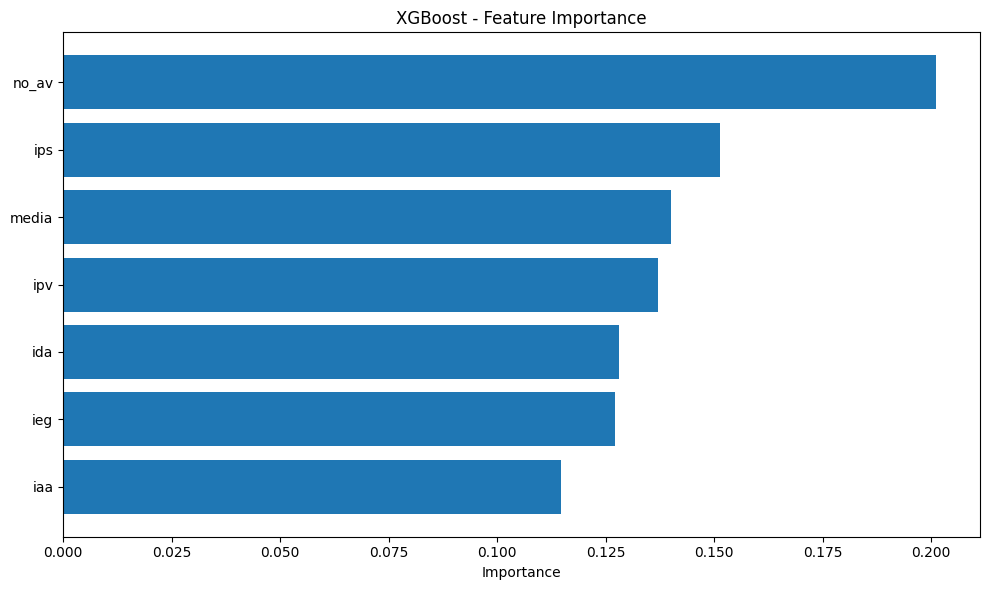

🏃 View run XGBoost_feature_importance at: http://localhost:5000/#/experiments/1/runs/889d503499994ebc802ee95fa0452784
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [12]:
# Feature Importance Analysis for XGBoost
# Based on gain (average improvement in accuracy from splits using the feature)
with mlflow.start_run(run_name="XGBoost_feature_importance"):
    feature_importance_xgb = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': xgb_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance (XGBoost):")
    print(feature_importance_xgb.to_string(index=False))
    
    # Log feature importances
    for idx, row in feature_importance_xgb.iterrows():
        mlflow.log_metric(f"feat_imp_{row['Feature']}", row['Importance'])
    
    # Visualize and log
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_xgb['Feature'], feature_importance_xgb['Importance'])
    plt.xlabel('Importance')
    plt.title('XGBoost - Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    
    fig_path = "xgb_feature_importance.png"
    plt.savefig(fig_path)
    mlflow.log_artifact(fig_path)
    plt.show()


ALGORITHM: LightGBM


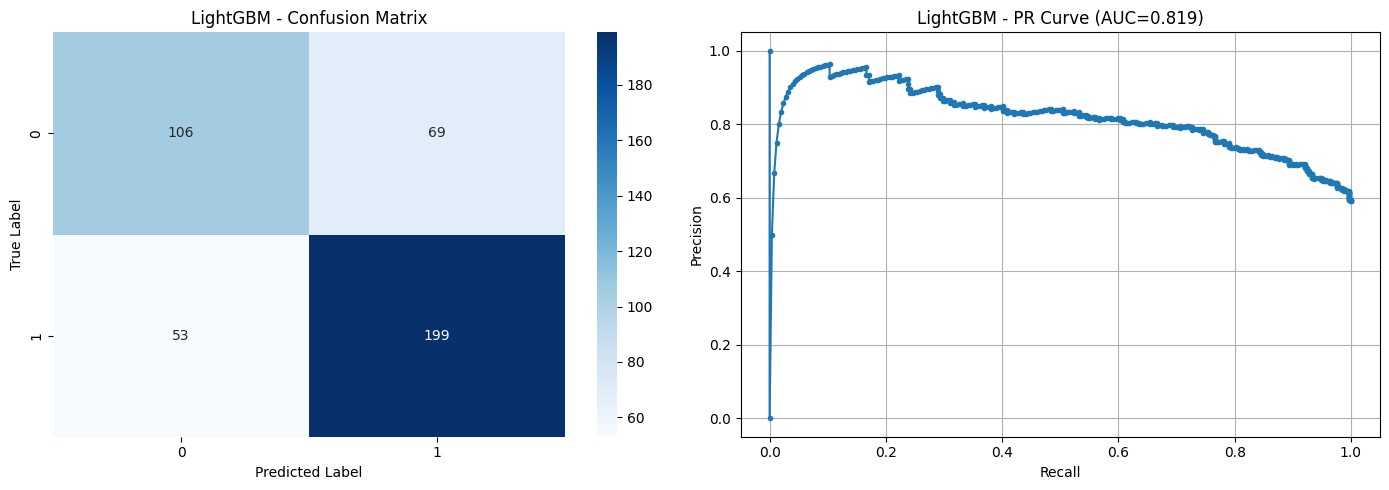

2026/02/12 22:16:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run LightGBM at: http://localhost:5000/#/experiments/1/runs/ed77c8cc67d64f3291e84c3907e7a056
🧪 View experiment at: http://localhost:5000/#/experiments/1

LightGBM - Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.61      0.63       175
           1       0.74      0.79      0.77       252

    accuracy                           0.71       427
   macro avg       0.70      0.70      0.70       427
weighted avg       0.71      0.71      0.71       427


Cross-Validation Metrics:
CV Recall: 0.776 ± 0.021
CV Precision: 0.771 ± 0.023
CV F1: 0.774 ± 0.019
CV ROC-AUC: 0.813 ± 0.020


In [13]:
from lightgbm import LGBMClassifier

print("\n" + "="*60)
print("ALGORITHM: LightGBM")
print("="*60)

lgbm = LGBMClassifier(
    n_estimators=100,          # Number of boosting iterations
    class_weight='balanced',   # Handle class imbalance
    random_state=RANDOM_STATE,
    verbose=-1                 # Suppress training output
)

# Evaluate and log to MLflow
lgbm_metrics, lgbm_model = evaluate_model(
    lgbm, X_train, y_train, X_val, y_val, 'LightGBM', log_to_mlflow=True
)

# Cross-validation
lgbm_cv = cross_val_metrics(lgbm, X_train, y_train)
print("\nCross-Validation Metrics:")
for k, v in lgbm_cv.items():
    print(f"{k}: {v}")


Feature Importance (LightGBM):
Feature  Importance
  media         748
    ida         499
    ipv         482
    ieg         450
    ips         342
    iaa         300
  no_av         179


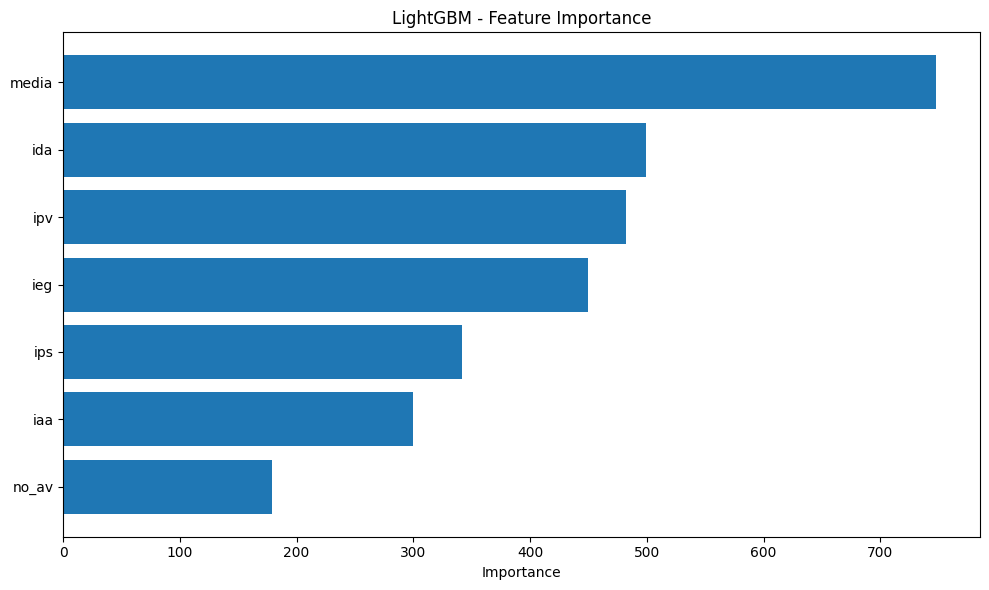

🏃 View run LightGBM_feature_importance at: http://localhost:5000/#/experiments/1/runs/e3cdad584e5c4d44b878b19377b8a025
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [14]:
# Feature Importance Analysis for LightGBM
# Based on split count (how many times feature is used to split data)
with mlflow.start_run(run_name="LightGBM_feature_importance"):
    feature_importance_lgbm = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': lgbm_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance (LightGBM):")
    print(feature_importance_lgbm.to_string(index=False))
    
    # Log feature importances
    for idx, row in feature_importance_lgbm.iterrows():
        mlflow.log_metric(f"feat_imp_{row['Feature']}", row['Importance'])
    
    # Visualize and log
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_lgbm['Feature'], feature_importance_lgbm['Importance'])
    plt.xlabel('Importance')
    plt.title('LightGBM - Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    
    fig_path = "lgbm_feature_importance.png"
    plt.savefig(fig_path)
    mlflow.log_artifact(fig_path)
    plt.show()

In [15]:
# Consolidate all results in a single dataframe
# Remove catboost_metrics from list if you didn't run CatBoost
all_results = pd.DataFrame([
    dummy_metrics,
    rf_metrics,
    xgb_metrics,
    lgbm_metrics,
])

print("\n" + "="*60)
print("FINAL COMPARISON - ALL MODELS")
print("="*60)
print(all_results.to_string(index=False))

# Identify best recall
best_recall_idx = all_results['Recall'].idxmax()
print(f"\nBest Recall: {all_results.loc[best_recall_idx, 'Model']} ({all_results.loc[best_recall_idx, 'Recall']:.3f})")

# Identify best PR-AUC (balanced metric for imbalanced data)
best_prauc_idx = all_results['PR-AUC'].idxmax()
print(f"Best PR-AUC: {all_results.loc[best_prauc_idx, 'Model']} ({all_results.loc[best_prauc_idx, 'PR-AUC']:.3f})")


FINAL COMPARISON - ALL MODELS
          Model   Recall  Precision       F1  ROC-AUC   PR-AUC
DummyClassifier 0.611111   0.626016 0.618474 0.542698 0.612074
   RandomForest 0.817460   0.673203 0.738351 0.678367 0.738965
        XGBoost 0.813492   0.762082 0.786948 0.789320 0.825912
       LightGBM 0.789683   0.742537 0.765385 0.778209 0.818560

Best Recall: RandomForest (0.817)
Best PR-AUC: XGBoost (0.826)


In [16]:
from sklearn.model_selection import GridSearchCV

print("\n" + "="*60)
print("HYPERPARAMETER TUNING: XGBoost (GridSearchCV)")
print("="*60)

# Start MLflow run for hyperparameter tuning
with mlflow.start_run(run_name="XGBoost_GridSearch"):
    
    # Define hyperparameter grid
    # Grid is intentionally small - expand based on computational resources
    param_grid_xgb = {
        'n_estimators': [100, 200, 300],           # Number of trees
        'max_depth': [3, 5, 7],                    # Maximum tree depth
        'learning_rate': [0.01, 0.05, 0.1],        # Step size shrinkage
        'subsample': [0.8, 1.0],                   # Fraction of samples for each tree
        'colsample_bytree': [0.8, 1.0],            # Fraction of features for each tree
        'min_child_weight': [1, 3, 5]              # Minimum sum of instance weight in a child
    }
    
    # Log search space
    mlflow.log_param("tuning_method", "GridSearchCV")
    mlflow.log_param("search_space_size", int(np.prod([len(v) for v in param_grid_xgb.values()])))
    mlflow.log_dict(param_grid_xgb, "param_grid.json")
    
    # Base estimator
    xgb_base = XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        random_state=RANDOM_STATE,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    # GridSearch with stratified cross-validation
    # WARNING: This can take a long time (hours) depending on grid size
    grid_search_xgb = GridSearchCV(
        estimator=xgb_base,
        param_grid=param_grid_xgb,
        scoring='recall',  # Optimize for recall
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
        n_jobs=-1,         # Use all CPU cores
        verbose=2          # Print progress
    )
    
    grid_search_xgb.fit(X_train, y_train)
    
    # Log best parameters
    mlflow.log_params(grid_search_xgb.best_params_)
    mlflow.log_metric("best_cv_recall", grid_search_xgb.best_score_)
    
    # Log all CV results
    cv_results_df = pd.DataFrame(grid_search_xgb.cv_results_)
    cv_results_path = "grid_search_cv_results.csv"
    cv_results_df.to_csv(cv_results_path, index=False)
    mlflow.log_artifact(cv_results_path)
    
    print("\nBest hyperparameters (XGBoost):")
    print(grid_search_xgb.best_params_)
    print(f"\nBest CV Recall: {grid_search_xgb.best_score_:.3f}")


HYPERPARAMETER TUNING: XGBoost (GridSearchCV)
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child

In [17]:
# Evaluate best XGBoost model on validation set
# Create a new run for the tuned model evaluation
with mlflow.start_run(run_name="XGBoost_Tuned_Validation"):
    
    best_xgb = grid_search_xgb.best_estimator_
    
    # Log best parameters again for this run
    mlflow.log_params(grid_search_xgb.best_params_)
    mlflow.log_param("tuned_with", "GridSearchCV")
    mlflow.log_param("scale_pos_weight", scale_pos_weight)
    
    y_pred_best = best_xgb.predict(X_val)
    y_proba_best = best_xgb.predict_proba(X_val)[:, 1]
    
    # Calculate metrics
    best_xgb_metrics = {
        'Model': 'XGBoost (Tuned)',
        'Recall': recall_score(y_val, y_pred_best),
        'Precision': precision_score(y_val, y_pred_best),
        'F1': f1_score(y_val, y_pred_best),
        'ROC-AUC': roc_auc_score(y_val, y_proba_best),
        'PR-AUC': average_precision_score(y_val, y_proba_best)
    }
    
    # Log metrics
    mlflow.log_metric("recall", best_xgb_metrics['Recall'])
    mlflow.log_metric("precision", best_xgb_metrics['Precision'])
    mlflow.log_metric("f1", best_xgb_metrics['F1'])
    mlflow.log_metric("roc_auc", best_xgb_metrics['ROC-AUC'])
    mlflow.log_metric("pr_auc", best_xgb_metrics['PR-AUC'])
    
    # Confusion matrix
    cm_best = confusion_matrix(y_val, y_pred_best)
    tn, fp, fn, tp = cm_best.ravel()
    mlflow.log_metric("true_negatives", int(tn))
    mlflow.log_metric("false_positives", int(fp))
    mlflow.log_metric("false_negatives", int(fn))
    mlflow.log_metric("true_positives", int(tp))
    
    # Log model
    mlflow.xgboost.log_model(best_xgb, "model")
    
    print("\n" + "="*60)
    print("XGBOOST TUNED - VALIDATION METRICS")
    print("="*60)
    for k, v in best_xgb_metrics.items():
        print(f"{k}: {v}")
    
    print("\nConfusion Matrix:")
    print(cm_best)
    
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred_best))

2026/02/12 22:16:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



XGBOOST TUNED - VALIDATION METRICS
Model: XGBoost (Tuned)
Recall: 0.8253968253968254
Precision: 0.7969348659003831
F1: 0.8109161793372319
ROC-AUC: 0.8441043083900226
PR-AUC: 0.8679520122087281

Confusion Matrix:
[[122  53]
 [ 44 208]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.70      0.72       175
           1       0.80      0.83      0.81       252

    accuracy                           0.77       427
   macro avg       0.77      0.76      0.76       427
weighted avg       0.77      0.77      0.77       427

🏃 View run XGBoost_Tuned_Validation at: http://localhost:5000/#/experiments/1/runs/81b2fc3f79ce4b35be00dbe483d35bc1
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [18]:
import optuna
from optuna.samplers import TPESampler
from optuna.integration.mlflow import MLflowCallback
import mlflow
import pandas as pd
import matplotlib.pyplot as plt  # caso precise gerar gráficos adicionais

# =============================================================================
# HYPERPARAMETER TUNING: XGBoost (Optuna + MLflow)
# =============================================================================
print("\n" + "="*60)
print("HYPERPARAMETER TUNING: XGBoost (Optuna)")
print("="*60)

# Configuração do callback MLflow
# O parâmetro nested=True é essencial para evitar conflito de runs ativos
mlflow_callback = MLflowCallback(
    tracking_uri=mlflow.get_tracking_uri(),
    metric_name="cv_recall",
    mlflow_kwargs={
        "nested": True,               # ← Solução principal para o erro
        "run_name_prefix": "trial_"   # Opcional: facilita identificar os trials
    }
)

def objective(trial):
    """
    Função objetivo para otimização com Optuna.
    Objetivo: Maximizar o recall médio na validação cruzada.
    
    Args:
        trial: Objeto Trial do Optuna para sugerir hiperparâmetros
    
    Returns:
        float: Média do recall nas folds de validação cruzada
    """
    # Sugestão inteligente dos hiperparâmetros
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
        'scale_pos_weight': scale_pos_weight,      # deve estar definido antes
        'random_state': RANDOM_STATE,              # deve estar definido antes
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'n_jobs': -1,                              # boa prática
        'verbosity': 0                             # evita poluição no console
    }

    # Instancia o modelo com os parâmetros sugeridos
    model = XGBClassifier(**params)

    # Validação cruzada estratificada
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    cv_scores = cross_validate(
        model,
        X_train,
        y_train,
        cv=skf,
        scoring='recall',
        n_jobs=-1,                  # paraleliza as folds
        return_train_score=False
    )

    # Retorna a média do recall
    mean_recall = cv_scores['test_score'].mean()
    
    # Opcional: registrar o valor intermediário para o Optuna acompanhar
    trial.set_user_attr("cv_recall_std", cv_scores['test_score'].std())
    
    return mean_recall


# =============================================================================
# Criação e execução do estudo
# =============================================================================

# Criação do estudo
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=RANDOM_STATE),
    study_name="xgboost_optuna_tuning",
    storage="sqlite:///optuna_xgboost_study.db",   # opcional: persiste o estudo
    load_if_exists=True                            # continua se já existir
)

# Executa a otimização (sem precisar de mlflow.start_run manual aqui)
study.optimize(
    objective,
    n_trials=100,
    callbacks=[mlflow_callback],
    show_progress_bar=True
)


# =============================================================================
# Registro dos resultados finais (fora do callback)
# =============================================================================

# Inicia um run pai apenas para registrar os resultados finais e artefatos
with mlflow.start_run(run_name="XGBoost_Optuna_Study_Final", nested=True):
    
    # Log dos parâmetros do estudo
    mlflow.log_param("tuning_method", "Optuna")
    mlflow.log_param("n_trials", 100)
    mlflow.log_param("sampler", "TPE")
    mlflow.log_param("n_trials_completed", len(study.trials))
    
    # Log dos melhores hiperparâmetros e métrica
    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_cv_recall", study.best_value)
    
    # Salva e registra o histórico completo
    trials_df = study.trials_dataframe()
    history_path = "optuna_trials_history.csv"
    trials_df.to_csv(history_path, index=False)
    mlflow.log_artifact(history_path)
    
    # Gráficos do Optuna (visualizações interativas)
    try:
        fig_history = optuna.visualization.plot_optimization_history(study)
        fig_history.write_html("optuna_optimization_history.html")
        mlflow.log_artifact("optuna_optimization_history.html")
        
        fig_importance = optuna.visualization.plot_param_importances(study)
        fig_importance.write_html("optuna_param_importance.html")
        mlflow.log_artifact("optuna_param_importance.html")
    except Exception as e:
        print(f"Erro ao gerar gráficos do Optuna: {e}")
    
    print("\n" + "="*60)
    print("MELHOR RESULTADO ENCONTRADO")
    print("="*60)
    print("Melhores hiperparâmetros:")
    print(study.best_params)
    print(f"\nMelhor Recall médio (CV): {study.best_value:.4f}")
    print(f"Número de trials concluídos: {len(study.trials)}")


HYPERPARAMETER TUNING: XGBoost (Optuna)


[I 2026-02-12 22:16:50,281] Using an existing study with name 'xgboost_optuna_tuning' instead of creating a new one.
  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-02-12 22:16:50,583] Trial 100 finished with value: 0.8306382978723403 and parameters: {'n_estimators': 403, 'max_depth': 4, 'learning_rate': 0.06519981492376446, 'subsample': 0.6517844523548012, 'colsample_bytree': 0.8982990026469979, 'min_child_weight': 1, 'gamma': 0.30519715478579396, 'reg_alpha': 0.948677104595322, 'reg_lambda': 0.26299605836552264}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:   1%|          | 1/100 [00:00<01:03,  1.56it/s]

🏃 View run 100 at: http://localhost:5000/#/experiments/2/runs/d1c787a779dc4a538da275b6350bc1bc
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:   1%|          | 1/100 [00:00<01:03,  1.56it/s]

[I 2026-02-12 22:16:51,176] Trial 101 finished with value: 0.8868085106382979 and parameters: {'n_estimators': 420, 'max_depth': 3, 'learning_rate': 0.2422460727346379, 'subsample': 0.7085599813844754, 'colsample_bytree': 0.868234754178455, 'min_child_weight': 2, 'gamma': 0.3042499594979062, 'reg_alpha': 0.6556609779059889, 'reg_lambda': 0.18551201160678657}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:   2%|▏         | 2/100 [00:01<01:01,  1.58it/s]

🏃 View run 101 at: http://localhost:5000/#/experiments/2/runs/371cbbbcf51f4a449ceddecfc9ae81da
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:   2%|▏         | 2/100 [00:01<01:01,  1.58it/s]

[I 2026-02-12 22:16:51,748] Trial 102 finished with value: 0.8868085106382978 and parameters: {'n_estimators': 456, 'max_depth': 3, 'learning_rate': 0.2777412794718583, 'subsample': 0.720286461443898, 'colsample_bytree': 0.8458346331083111, 'min_child_weight': 2, 'gamma': 0.3297223613180842, 'reg_alpha': 0.7532243940264722, 'reg_lambda': 0.23013201337618208}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:   3%|▎         | 3/100 [00:01<00:57,  1.69it/s]

🏃 View run 102 at: http://localhost:5000/#/experiments/2/runs/c9cf8cfbecce4bf69397488dbdf3f777
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:   3%|▎         | 3/100 [00:02<00:57,  1.69it/s]

[I 2026-02-12 22:16:52,343] Trial 103 finished with value: 0.8774468085106383 and parameters: {'n_estimators': 449, 'max_depth': 3, 'learning_rate': 0.2530208713529776, 'subsample': 0.7339233905539704, 'colsample_bytree': 0.8558331807828794, 'min_child_weight': 2, 'gamma': 0.3452497033795359, 'reg_alpha': 0.6882295119501993, 'reg_lambda': 0.25155615539781456}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:   4%|▍         | 4/100 [00:02<00:57,  1.66it/s]

🏃 View run 103 at: http://localhost:5000/#/experiments/2/runs/508d06fb18a44e8ebd0282a66a8f19b6
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:   4%|▍         | 4/100 [00:02<00:57,  1.66it/s]

[I 2026-02-12 22:16:52,966] Trial 104 finished with value: 0.8902127659574468 and parameters: {'n_estimators': 467, 'max_depth': 3, 'learning_rate': 0.22361544567965289, 'subsample': 0.6815464126323525, 'colsample_bytree': 0.8760843125778828, 'min_child_weight': 1, 'gamma': 0.29601517383078174, 'reg_alpha': 0.611533967784195, 'reg_lambda': 0.33389937817962434}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:   5%|▌         | 5/100 [00:03<00:57,  1.66it/s]

🏃 View run 104 at: http://localhost:5000/#/experiments/2/runs/7c0ff5f43f364154b61bb225dd0ce18b
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:   5%|▌         | 5/100 [00:03<00:57,  1.66it/s]

[I 2026-02-12 22:16:53,546] Trial 105 finished with value: 0.8961702127659574 and parameters: {'n_estimators': 494, 'max_depth': 3, 'learning_rate': 0.23883683290357674, 'subsample': 0.686800769113479, 'colsample_bytree': 0.9074516386653706, 'min_child_weight': 1, 'gamma': 0.3554195017489985, 'reg_alpha': 0.5266869482484055, 'reg_lambda': 0.09375895229594663}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:   6%|▌         | 6/100 [00:03<00:56,  1.66it/s]

🏃 View run 105 at: http://localhost:5000/#/experiments/2/runs/ff35f260f03744db8a76178b34a4aac9
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:   6%|▌         | 6/100 [00:03<00:56,  1.66it/s]

[I 2026-02-12 22:16:54,149] Trial 106 finished with value: 0.901276595744681 and parameters: {'n_estimators': 498, 'max_depth': 3, 'learning_rate': 0.28709472275616366, 'subsample': 0.6338692254757754, 'colsample_bytree': 0.9054989579659412, 'min_child_weight': 1, 'gamma': 0.35096788282036256, 'reg_alpha': 0.5419895642387942, 'reg_lambda': 0.08711041961800714}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:   7%|▋         | 7/100 [00:04<00:55,  1.68it/s]

🏃 View run 106 at: http://localhost:5000/#/experiments/2/runs/fa2196bd1d6247fa92a34e9dd7484e95
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:   7%|▋         | 7/100 [00:04<00:55,  1.68it/s]

[I 2026-02-12 22:16:54,731] Trial 107 finished with value: 0.8876595744680851 and parameters: {'n_estimators': 495, 'max_depth': 3, 'learning_rate': 0.1923333442409355, 'subsample': 0.6915654803724224, 'colsample_bytree': 0.90297560764248, 'min_child_weight': 1, 'gamma': 0.35539112961943614, 'reg_alpha': 0.5094778061577878, 'reg_lambda': 0.0541310683485491}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:   8%|▊         | 8/100 [00:04<00:54,  1.69it/s]

🏃 View run 107 at: http://localhost:5000/#/experiments/2/runs/597acb83372c49f888ae92f739d0212d
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:   8%|▊         | 8/100 [00:05<00:54,  1.69it/s]

[I 2026-02-12 22:16:55,295] Trial 108 finished with value: 0.8944680851063829 and parameters: {'n_estimators': 480, 'max_depth': 3, 'learning_rate': 0.2326800729490979, 'subsample': 0.6839848221184569, 'colsample_bytree': 0.9186733959879277, 'min_child_weight': 1, 'gamma': 0.3915867536766881, 'reg_alpha': 0.426780231550129, 'reg_lambda': 0.11117691470483367}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:   9%|▉         | 9/100 [00:05<00:54,  1.68it/s]

🏃 View run 108 at: http://localhost:5000/#/experiments/2/runs/fd9f6d3f703e407b9044806e7df39da5
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:   9%|▉         | 9/100 [00:05<00:54,  1.68it/s]

[I 2026-02-12 22:16:55,946] Trial 109 finished with value: 0.8851063829787232 and parameters: {'n_estimators': 481, 'max_depth': 4, 'learning_rate': 0.23185399802598539, 'subsample': 0.6761196008707999, 'colsample_bytree': 0.9156788817991688, 'min_child_weight': 6, 'gamma': 0.38845979536440745, 'reg_alpha': 0.43089161114036256, 'reg_lambda': 0.10162367821305711}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  10%|█         | 10/100 [00:06<00:53,  1.68it/s]

🏃 View run 109 at: http://localhost:5000/#/experiments/2/runs/8e36c93599d9454c839796606dad86fb
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  10%|█         | 10/100 [00:06<00:53,  1.68it/s]

[I 2026-02-12 22:16:56,505] Trial 110 finished with value: 0.8902127659574468 and parameters: {'n_estimators': 493, 'max_depth': 3, 'learning_rate': 0.2072519164911657, 'subsample': 0.7033894602614776, 'colsample_bytree': 0.9081832446791708, 'min_child_weight': 1, 'gamma': 0.43304027960239594, 'reg_alpha': 0.4859657468280536, 'reg_lambda': 0.03118292640117913}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  11%|█         | 11/100 [00:06<00:52,  1.71it/s]

🏃 View run 110 at: http://localhost:5000/#/experiments/2/runs/a946dc6cfb824ef9bbd8925fdc027342
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  11%|█         | 11/100 [00:06<00:52,  1.71it/s]

[I 2026-02-12 22:16:57,079] Trial 111 finished with value: 0.8902127659574468 and parameters: {'n_estimators': 471, 'max_depth': 3, 'learning_rate': 0.2880231081578102, 'subsample': 0.6832605683401114, 'colsample_bytree': 0.8864528223913908, 'min_child_weight': 1, 'gamma': 0.37807919552930574, 'reg_alpha': 0.5340324158645009, 'reg_lambda': 0.08510773958396434}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  12%|█▏        | 12/100 [00:07<00:51,  1.70it/s]

🏃 View run 111 at: http://localhost:5000/#/experiments/2/runs/19fdfd24c8104219a3cf41fd34d08310
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  12%|█▏        | 12/100 [00:07<00:51,  1.70it/s]

[I 2026-02-12 22:16:57,670] Trial 112 finished with value: 0.8902127659574468 and parameters: {'n_estimators': 481, 'max_depth': 3, 'learning_rate': 0.29972324928817085, 'subsample': 0.6615793747086608, 'colsample_bytree': 0.8907652326967683, 'min_child_weight': 1, 'gamma': 0.39903054696444196, 'reg_alpha': 0.8274084818660905, 'reg_lambda': 0.1299606158663821}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  13%|█▎        | 13/100 [00:07<00:50,  1.71it/s]

🏃 View run 112 at: http://localhost:5000/#/experiments/2/runs/9ac7850ca35040dbaaca0546d4d72be9
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  13%|█▎        | 13/100 [00:07<00:50,  1.71it/s]

[I 2026-02-12 22:16:58,282] Trial 113 finished with value: 0.902127659574468 and parameters: {'n_estimators': 499, 'max_depth': 3, 'learning_rate': 0.2619873228341202, 'subsample': 0.6516504176614335, 'colsample_bytree': 0.9254465344271715, 'min_child_weight': 1, 'gamma': 0.31914843842253404, 'reg_alpha': 0.42440305294350356, 'reg_lambda': 0.10731581327742779}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  14%|█▍        | 14/100 [00:08<00:50,  1.69it/s]

🏃 View run 113 at: http://localhost:5000/#/experiments/2/runs/1e6fc74a7e0642eb99490f6fcb6d1dd4
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  14%|█▍        | 14/100 [00:08<00:50,  1.69it/s]

[I 2026-02-12 22:16:58,839] Trial 114 finished with value: 0.9012765957446808 and parameters: {'n_estimators': 494, 'max_depth': 3, 'learning_rate': 0.2572102820175893, 'subsample': 0.6223313619872521, 'colsample_bytree': 0.9291844107595144, 'min_child_weight': 1, 'gamma': 0.35666339496627647, 'reg_alpha': 0.5212088636248439, 'reg_lambda': 0.10327851744025342}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  15%|█▌        | 15/100 [00:08<00:49,  1.71it/s]

🏃 View run 114 at: http://localhost:5000/#/experiments/2/runs/a02ac0df80f54389bfc3bcf4b4d85564
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  15%|█▌        | 15/100 [00:09<00:49,  1.71it/s]

[I 2026-02-12 22:16:59,439] Trial 115 finished with value: 0.8927659574468085 and parameters: {'n_estimators': 499, 'max_depth': 3, 'learning_rate': 0.23965719844713798, 'subsample': 0.6182159871633093, 'colsample_bytree': 0.9231355092118959, 'min_child_weight': 1, 'gamma': 0.33515103957661285, 'reg_alpha': 0.41955938505786283, 'reg_lambda': 0.09328944651181746}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  16%|█▌        | 16/100 [00:09<00:49,  1.70it/s]

🏃 View run 115 at: http://localhost:5000/#/experiments/2/runs/48f61a8dbfa24fb9981b8b4ab19472af
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  16%|█▌        | 16/100 [00:09<00:49,  1.70it/s]

[I 2026-02-12 22:17:00,063] Trial 116 finished with value: 0.8995744680851064 and parameters: {'n_estimators': 492, 'max_depth': 3, 'learning_rate': 0.25548388955834866, 'subsample': 0.6484261972023763, 'colsample_bytree': 0.9284597006201251, 'min_child_weight': 2, 'gamma': 0.351644914899952, 'reg_alpha': 0.45565387102958355, 'reg_lambda': 0.12231873409984674}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  17%|█▋        | 17/100 [00:10<00:50,  1.66it/s]

🏃 View run 116 at: http://localhost:5000/#/experiments/2/runs/f75bd723c0934bba989f99dedd03fdc4
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  17%|█▋        | 17/100 [00:10<00:50,  1.66it/s]

[I 2026-02-12 22:17:00,683] Trial 117 finished with value: 0.7974468085106383 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.04602716010304527, 'subsample': 0.6370534742282505, 'colsample_bytree': 0.919304507792749, 'min_child_weight': 1, 'gamma': 0.35345899854323193, 'reg_alpha': 0.43645021580461085, 'reg_lambda': 0.030485874168415847}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  18%|█▊        | 18/100 [00:10<00:50,  1.64it/s]

🏃 View run 117 at: http://localhost:5000/#/experiments/2/runs/44106d8252aa484e8e8c6bd637f241eb
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  18%|█▊        | 18/100 [00:10<00:50,  1.64it/s]

[I 2026-02-12 22:17:01,273] Trial 118 finished with value: 0.8927659574468085 and parameters: {'n_estimators': 487, 'max_depth': 3, 'learning_rate': 0.257435437781623, 'subsample': 0.6495418867575192, 'colsample_bytree': 0.9316838483172496, 'min_child_weight': 2, 'gamma': 0.36246007859654683, 'reg_alpha': 0.37024503397848557, 'reg_lambda': 0.13411646571507427}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  19%|█▉        | 19/100 [00:11<00:48,  1.68it/s]

🏃 View run 118 at: http://localhost:5000/#/experiments/2/runs/87b03053b4b142ffaf1bcc5aea3a31da
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  19%|█▉        | 19/100 [00:11<00:48,  1.68it/s]

[I 2026-02-12 22:17:01,838] Trial 119 finished with value: 0.8800000000000001 and parameters: {'n_estimators': 493, 'max_depth': 4, 'learning_rate': 0.21844455643724267, 'subsample': 0.62519810905447, 'colsample_bytree': 0.9115263578004106, 'min_child_weight': 1, 'gamma': 0.3752326457571522, 'reg_alpha': 0.4597108907480355, 'reg_lambda': 0.11264318621781408}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  20%|██        | 20/100 [00:11<00:47,  1.69it/s]

🏃 View run 119 at: http://localhost:5000/#/experiments/2/runs/bcc4e1b100eb4abbb392d28c8475b579
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  20%|██        | 20/100 [00:12<00:47,  1.69it/s]

[I 2026-02-12 22:17:02,419] Trial 120 finished with value: 0.8782978723404256 and parameters: {'n_estimators': 483, 'max_depth': 3, 'learning_rate': 0.18381345200797408, 'subsample': 0.6453565451887364, 'colsample_bytree': 0.9027315848096021, 'min_child_weight': 1, 'gamma': 0.21629058162710896, 'reg_alpha': 0.518897825943003, 'reg_lambda': 0.17264379511311684}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  21%|██        | 21/100 [00:12<00:46,  1.71it/s]

🏃 View run 120 at: http://localhost:5000/#/experiments/2/runs/4de1bf9f019642b98d66b7de5bf76781
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  21%|██        | 21/100 [00:12<00:46,  1.71it/s]

[I 2026-02-12 22:17:03,026] Trial 121 finished with value: 0.9004255319148935 and parameters: {'n_estimators': 493, 'max_depth': 3, 'learning_rate': 0.25448565780494387, 'subsample': 0.6368180349373999, 'colsample_bytree': 0.9419342378093412, 'min_child_weight': 2, 'gamma': 0.4563569710240194, 'reg_alpha': 0.4899197924611948, 'reg_lambda': 0.060876172881498894}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  22%|██▏       | 22/100 [00:13<00:46,  1.69it/s]

🏃 View run 121 at: http://localhost:5000/#/experiments/2/runs/9fe2da85c81147d0bab1dab0febd7986
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  22%|██▏       | 22/100 [00:13<00:46,  1.69it/s]

[I 2026-02-12 22:17:03,620] Trial 122 finished with value: 0.902127659574468 and parameters: {'n_estimators': 493, 'max_depth': 3, 'learning_rate': 0.25712942475458705, 'subsample': 0.6553961110803384, 'colsample_bytree': 0.9417546793265629, 'min_child_weight': 2, 'gamma': 0.459627177028224, 'reg_alpha': 0.40505273441176226, 'reg_lambda': 0.060354643542425916}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  23%|██▎       | 23/100 [00:13<00:45,  1.68it/s]

🏃 View run 122 at: http://localhost:5000/#/experiments/2/runs/872eb34970e34fc3a683ec5a4f159586
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  23%|██▎       | 23/100 [00:13<00:45,  1.68it/s]

[I 2026-02-12 22:17:04,195] Trial 123 finished with value: 0.8919148936170214 and parameters: {'n_estimators': 492, 'max_depth': 3, 'learning_rate': 0.2530929333785787, 'subsample': 0.6113752323070976, 'colsample_bytree': 0.942136662209176, 'min_child_weight': 3, 'gamma': 0.47143878650512533, 'reg_alpha': 0.4835058598735088, 'reg_lambda': 0.029708249118550495}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  24%|██▍       | 24/100 [00:14<00:44,  1.71it/s]

🏃 View run 123 at: http://localhost:5000/#/experiments/2/runs/f083724c3aca4fb8b93328c4c099c4bc
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  24%|██▍       | 24/100 [00:14<00:44,  1.71it/s]

[I 2026-02-12 22:17:04,787] Trial 124 finished with value: 0.8859574468085105 and parameters: {'n_estimators': 484, 'max_depth': 3, 'learning_rate': 0.19856444762969125, 'subsample': 0.6360233702305425, 'colsample_bytree': 0.9612291658386908, 'min_child_weight': 2, 'gamma': 0.4781937315712837, 'reg_alpha': 0.40363031452041404, 'reg_lambda': 0.06188136686260938}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  25%|██▌       | 25/100 [00:14<00:44,  1.69it/s]

🏃 View run 124 at: http://localhost:5000/#/experiments/2/runs/811dc3e2798a4a418dff19b9f7d6fb99
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  25%|██▌       | 25/100 [00:15<00:44,  1.69it/s]

[I 2026-02-12 22:17:05,383] Trial 125 finished with value: 0.8868085106382979 and parameters: {'n_estimators': 499, 'max_depth': 3, 'learning_rate': 0.2307095533387177, 'subsample': 0.6532656440136257, 'colsample_bytree': 0.9233951107310234, 'min_child_weight': 2, 'gamma': 0.4696946011507047, 'reg_alpha': 0.5762713690718254, 'reg_lambda': 0.1460576138927983}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  26%|██▌       | 26/100 [00:15<00:43,  1.71it/s]

🏃 View run 125 at: http://localhost:5000/#/experiments/2/runs/e62cbddb90914ccf990c700e54371931
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  26%|██▌       | 26/100 [00:15<00:43,  1.71it/s]

[I 2026-02-12 22:17:05,919] Trial 126 finished with value: 0.8868085106382978 and parameters: {'n_estimators': 466, 'max_depth': 3, 'learning_rate': 0.28800279382591215, 'subsample': 0.6236947579017856, 'colsample_bytree': 0.9303074257822583, 'min_child_weight': 3, 'gamma': 0.44832808924915246, 'reg_alpha': 0.38165978009302026, 'reg_lambda': 0.1155333726165243}. Best is trial 68 with value: 0.9038297872340426.


Best trial: 68. Best value: 0.90383:  27%|██▋       | 27/100 [00:15<00:41,  1.74it/s]

🏃 View run 126 at: http://localhost:5000/#/experiments/2/runs/ae8cf6eb9f8a41fb9267bbfc28d8123d
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 68. Best value: 0.90383:  27%|██▋       | 27/100 [00:16<00:41,  1.74it/s]

[I 2026-02-12 22:17:06,472] Trial 127 finished with value: 0.912340425531915 and parameters: {'n_estimators': 491, 'max_depth': 3, 'learning_rate': 0.29955720263572994, 'subsample': 0.642469645175394, 'colsample_bytree': 0.9378744522176313, 'min_child_weight': 2, 'gamma': 0.4468785979783484, 'reg_alpha': 0.45072828540091214, 'reg_lambda': 0.07933724875824494}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  28%|██▊       | 28/100 [00:16<00:40,  1.76it/s]

🏃 View run 127 at: http://localhost:5000/#/experiments/2/runs/004c3a2e65844ccdb3ecc8b6fe9b5a46
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  28%|██▊       | 28/100 [00:16<00:40,  1.76it/s]

[I 2026-02-12 22:17:07,027] Trial 128 finished with value: 0.8680851063829789 and parameters: {'n_estimators': 493, 'max_depth': 3, 'learning_rate': 0.2992039527513066, 'subsample': 0.6383639166049532, 'colsample_bytree': 0.6835684569462417, 'min_child_weight': 2, 'gamma': 0.4853231009568991, 'reg_alpha': 0.46042261590616484, 'reg_lambda': 0.001031897531531073}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  29%|██▉       | 29/100 [00:17<00:40,  1.76it/s]

🏃 View run 128 at: http://localhost:5000/#/experiments/2/runs/009732fcc6fd48afafdc318f865bca1c
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  29%|██▉       | 29/100 [00:17<00:40,  1.76it/s]

[I 2026-02-12 22:17:07,603] Trial 129 finished with value: 0.8834042553191489 and parameters: {'n_estimators': 472, 'max_depth': 3, 'learning_rate': 0.2547361440185288, 'subsample': 0.608247641648832, 'colsample_bytree': 0.9552431428792936, 'min_child_weight': 2, 'gamma': 0.44437007018697045, 'reg_alpha': 0.5364957500281616, 'reg_lambda': 0.08312635877573747}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  30%|███       | 30/100 [00:17<00:39,  1.75it/s]

🏃 View run 129 at: http://localhost:5000/#/experiments/2/runs/7e0845d8358f45c7865c19eef5e1501c
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  30%|███       | 30/100 [00:17<00:39,  1.75it/s]

[I 2026-02-12 22:17:08,203] Trial 130 finished with value: 0.8842553191489362 and parameters: {'n_estimators': 488, 'max_depth': 4, 'learning_rate': 0.2676088220745436, 'subsample': 0.6558140336533428, 'colsample_bytree': 0.9418083106416149, 'min_child_weight': 2, 'gamma': 0.456727335876629, 'reg_alpha': 0.49733773526708924, 'reg_lambda': 0.04883344341389273}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  31%|███       | 31/100 [00:18<00:40,  1.70it/s]

🏃 View run 130 at: http://localhost:5000/#/experiments/2/runs/78066e743fa94918902aba922ce6a01f
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  31%|███       | 31/100 [00:18<00:40,  1.70it/s]

[I 2026-02-12 22:17:08,807] Trial 131 finished with value: 0.8851063829787232 and parameters: {'n_estimators': 480, 'max_depth': 3, 'learning_rate': 0.28179319190247437, 'subsample': 0.6713780714157324, 'colsample_bytree': 0.9184829927493913, 'min_child_weight': 1, 'gamma': 0.4982498260714302, 'reg_alpha': 0.3342492092432078, 'reg_lambda': 0.0723413047042179}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  32%|███▏      | 32/100 [00:18<00:39,  1.72it/s]

🏃 View run 131 at: http://localhost:5000/#/experiments/2/runs/616f0f70dacf474cb33dd4f10eb14be6
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  32%|███▏      | 32/100 [00:19<00:39,  1.72it/s]

[I 2026-02-12 22:17:09,373] Trial 132 finished with value: 0.8459574468085107 and parameters: {'n_estimators': 477, 'max_depth': 3, 'learning_rate': 0.23460941246038647, 'subsample': 0.6437467050578307, 'colsample_bytree': 0.937169620291899, 'min_child_weight': 10, 'gamma': 0.4044083897884068, 'reg_alpha': 0.41926201493490567, 'reg_lambda': 0.10043269369923902}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  33%|███▎      | 33/100 [00:19<00:38,  1.72it/s]

🏃 View run 132 at: http://localhost:5000/#/experiments/2/runs/553c5baf983b47db89403aabfb085519
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  33%|███▎      | 33/100 [00:19<00:38,  1.72it/s]

[I 2026-02-12 22:17:09,967] Trial 133 finished with value: 0.9004255319148935 and parameters: {'n_estimators': 492, 'max_depth': 3, 'learning_rate': 0.2534477260487092, 'subsample': 0.6304239576830853, 'colsample_bytree': 0.9517849609096749, 'min_child_weight': 2, 'gamma': 0.18682493483084986, 'reg_alpha': 0.441269318616605, 'reg_lambda': 0.11866352123477478}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  34%|███▍      | 34/100 [00:20<00:38,  1.73it/s]

🏃 View run 133 at: http://localhost:5000/#/experiments/2/runs/be5f2e95197f44b3a6bb894568d0fa07
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  34%|███▍      | 34/100 [00:20<00:38,  1.73it/s]

[I 2026-02-12 22:17:10,541] Trial 134 finished with value: 0.8987234042553192 and parameters: {'n_estimators': 499, 'max_depth': 3, 'learning_rate': 0.25561635522711, 'subsample': 0.6279104588009348, 'colsample_bytree': 0.9643722741305253, 'min_child_weight': 3, 'gamma': 0.20500658202036037, 'reg_alpha': 0.45122709396037514, 'reg_lambda': 0.14772344042249647}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  35%|███▌      | 35/100 [00:20<00:37,  1.73it/s]

🏃 View run 134 at: http://localhost:5000/#/experiments/2/runs/11af8fc4a6314e3c97172e6d758b211d
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  35%|███▌      | 35/100 [00:20<00:37,  1.73it/s]

[I 2026-02-12 22:17:11,121] Trial 135 finished with value: 0.745531914893617 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.024913145338318916, 'subsample': 0.620473015722956, 'colsample_bytree': 0.9656724048098841, 'min_child_weight': 3, 'gamma': 0.4579391036413254, 'reg_alpha': 0.4510056152470223, 'reg_lambda': 0.13980225627843887}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  36%|███▌      | 36/100 [00:21<00:38,  1.68it/s]

🏃 View run 135 at: http://localhost:5000/#/experiments/2/runs/9d0018f7819f40ecaf0a18ce9171446f
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  36%|███▌      | 36/100 [00:21<00:38,  1.68it/s]

[I 2026-02-12 22:17:11,789] Trial 136 finished with value: 0.8689361702127659 and parameters: {'n_estimators': 490, 'max_depth': 7, 'learning_rate': 0.21603715870591406, 'subsample': 0.6320707747716799, 'colsample_bytree': 0.951197010186525, 'min_child_weight': 3, 'gamma': 0.22836933422404537, 'reg_alpha': 0.49096060995705565, 'reg_lambda': 0.1756433144133225}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  37%|███▋      | 37/100 [00:21<00:37,  1.66it/s]

🏃 View run 136 at: http://localhost:5000/#/experiments/2/runs/1a59e74a62c04331a8ffb87e046e7373
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  37%|███▋      | 37/100 [00:22<00:37,  1.66it/s]

[I 2026-02-12 22:17:12,364] Trial 137 finished with value: 0.8936170212765958 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.25236678990491657, 'subsample': 0.6093758233225519, 'colsample_bytree': 0.9274346645538083, 'min_child_weight': 2, 'gamma': 0.18128943683048127, 'reg_alpha': 0.36518828173566886, 'reg_lambda': 0.04806918108098728}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  38%|███▊      | 38/100 [00:22<00:36,  1.69it/s]

🏃 View run 137 at: http://localhost:5000/#/experiments/2/runs/5d5613dee74c4de193b347aed0ffffc6
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  38%|███▊      | 38/100 [00:22<00:36,  1.69it/s]

[I 2026-02-12 22:17:12,930] Trial 138 finished with value: 0.908936170212766 and parameters: {'n_estimators': 487, 'max_depth': 3, 'learning_rate': 0.2986163911624351, 'subsample': 0.6475685575023875, 'colsample_bytree': 0.9465150466231173, 'min_child_weight': 2, 'gamma': 0.20889481159990175, 'reg_alpha': 0.46519857770739265, 'reg_lambda': 0.08353976467055102}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  39%|███▉      | 39/100 [00:22<00:35,  1.71it/s]

🏃 View run 138 at: http://localhost:5000/#/experiments/2/runs/6839a97c8de74d0a8bb2871b7bd2e40f
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  39%|███▉      | 39/100 [00:23<00:35,  1.71it/s]

[I 2026-02-12 22:17:13,518] Trial 139 finished with value: 0.8919148936170214 and parameters: {'n_estimators': 465, 'max_depth': 3, 'learning_rate': 0.2838808591058661, 'subsample': 0.6471223830807881, 'colsample_bytree': 0.9459932431975472, 'min_child_weight': 3, 'gamma': 0.20907021955862748, 'reg_alpha': 0.4687340044900045, 'reg_lambda': 0.15203626528123101}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  40%|████      | 40/100 [00:23<00:35,  1.70it/s]

🏃 View run 139 at: http://localhost:5000/#/experiments/2/runs/6c5d9d25ff304031bace5ebbfcd429f6
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  40%|████      | 40/100 [00:23<00:35,  1.70it/s]

[I 2026-02-12 22:17:14,085] Trial 140 finished with value: 0.8961702127659574 and parameters: {'n_estimators': 485, 'max_depth': 3, 'learning_rate': 0.2621106553238609, 'subsample': 0.6383481325002645, 'colsample_bytree': 0.9721432996938689, 'min_child_weight': 2, 'gamma': 0.41600566649571513, 'reg_alpha': 0.4455218861266544, 'reg_lambda': 0.022642062767671195}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  41%|████      | 41/100 [00:24<00:34,  1.73it/s]

🏃 View run 140 at: http://localhost:5000/#/experiments/2/runs/aeb9d6911a354b909fb9f2030ee4803e
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  41%|████      | 41/100 [00:24<00:34,  1.73it/s]

[I 2026-02-12 22:17:14,652] Trial 141 finished with value: 0.9012765957446808 and parameters: {'n_estimators': 490, 'max_depth': 3, 'learning_rate': 0.2996146340318284, 'subsample': 0.6582391002849328, 'colsample_bytree': 0.9365198110169847, 'min_child_weight': 2, 'gamma': 0.20244062141483293, 'reg_alpha': 0.5012262172720359, 'reg_lambda': 0.08287669999983698}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  42%|████▏     | 42/100 [00:24<00:33,  1.74it/s]

🏃 View run 141 at: http://localhost:5000/#/experiments/2/runs/96942d6b6d6e447688c0895118241eab
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  42%|████▏     | 42/100 [00:24<00:33,  1.74it/s]

[I 2026-02-12 22:17:15,201] Trial 142 finished with value: 0.8995744680851063 and parameters: {'n_estimators': 474, 'max_depth': 3, 'learning_rate': 0.2948177587241016, 'subsample': 0.6559638810757542, 'colsample_bytree': 0.9416874200143038, 'min_child_weight': 2, 'gamma': 0.19246057217175438, 'reg_alpha': 0.3975862530333231, 'reg_lambda': 0.07284083731183166}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  43%|████▎     | 43/100 [00:25<00:32,  1.76it/s]

🏃 View run 142 at: http://localhost:5000/#/experiments/2/runs/4c1617e86a904e3cab934a36e527596e
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  43%|████▎     | 43/100 [00:25<00:32,  1.76it/s]

[I 2026-02-12 22:17:15,827] Trial 143 finished with value: 0.897872340425532 and parameters: {'n_estimators': 474, 'max_depth': 3, 'learning_rate': 0.29635234262590365, 'subsample': 0.6607864762908168, 'colsample_bytree': 0.9373083691534154, 'min_child_weight': 2, 'gamma': 0.1907616002787803, 'reg_alpha': 0.417627780071472, 'reg_lambda': 0.07549852943326806}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  44%|████▍     | 44/100 [00:25<00:32,  1.71it/s]

🏃 View run 143 at: http://localhost:5000/#/experiments/2/runs/edfc5fa8596944b5a316d9b89486639f
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  44%|████▍     | 44/100 [00:26<00:32,  1.71it/s]

[I 2026-02-12 22:17:16,436] Trial 144 finished with value: 0.9029787234042553 and parameters: {'n_estimators': 488, 'max_depth': 3, 'learning_rate': 0.2972611568370642, 'subsample': 0.6545906459517266, 'colsample_bytree': 0.9475931100284378, 'min_child_weight': 2, 'gamma': 0.1992341046091172, 'reg_alpha': 0.5086931630812597, 'reg_lambda': 0.06452264933192119}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  45%|████▌     | 45/100 [00:26<00:32,  1.67it/s]

🏃 View run 144 at: http://localhost:5000/#/experiments/2/runs/5f0e0ec6299b4529a9fd7b8084f52084
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  45%|████▌     | 45/100 [00:26<00:32,  1.67it/s]

[I 2026-02-12 22:17:17,043] Trial 145 finished with value: 0.9046808510638297 and parameters: {'n_estimators': 463, 'max_depth': 3, 'learning_rate': 0.283254556212094, 'subsample': 0.6539528855491072, 'colsample_bytree': 0.9507974509476947, 'min_child_weight': 2, 'gamma': 0.1947454700509754, 'reg_alpha': 0.4053073766881902, 'reg_lambda': 0.05043801598273802}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  46%|████▌     | 46/100 [00:27<00:32,  1.67it/s]

🏃 View run 145 at: http://localhost:5000/#/experiments/2/runs/5af855f8a58c4479b74627b87648d570
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  46%|████▌     | 46/100 [00:27<00:32,  1.67it/s]

[I 2026-02-12 22:17:17,654] Trial 146 finished with value: 0.9004255319148935 and parameters: {'n_estimators': 467, 'max_depth': 3, 'learning_rate': 0.29698939920578543, 'subsample': 0.6563100782741519, 'colsample_bytree': 0.9504288599169844, 'min_child_weight': 2, 'gamma': 0.19682210015613663, 'reg_alpha': 0.3904037035656055, 'reg_lambda': 0.04771506631375504}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  47%|████▋     | 47/100 [00:27<00:32,  1.65it/s]

🏃 View run 146 at: http://localhost:5000/#/experiments/2/runs/a1f80edf2ff140129020c981cc1d168f
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  47%|████▋     | 47/100 [00:27<00:32,  1.65it/s]

[I 2026-02-12 22:17:18,256] Trial 147 finished with value: 0.9046808510638297 and parameters: {'n_estimators': 467, 'max_depth': 3, 'learning_rate': 0.27816414160081243, 'subsample': 0.6506608133001451, 'colsample_bytree': 0.9559796659689622, 'min_child_weight': 2, 'gamma': 0.186485238560389, 'reg_alpha': 0.506468846519423, 'reg_lambda': 0.04766161538542856}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  48%|████▊     | 48/100 [00:28<00:31,  1.66it/s]

🏃 View run 147 at: http://localhost:5000/#/experiments/2/runs/ff06afef5c884c958f09cfaef892fab8
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  48%|████▊     | 48/100 [00:28<00:31,  1.66it/s]

[I 2026-02-12 22:17:18,807] Trial 148 finished with value: 0.8953191489361702 and parameters: {'n_estimators': 462, 'max_depth': 3, 'learning_rate': 0.28340864170695096, 'subsample': 0.6418815333186353, 'colsample_bytree': 0.9546992313065991, 'min_child_weight': 2, 'gamma': 0.17749181538920022, 'reg_alpha': 0.5096609369126875, 'reg_lambda': 0.0417845947044631}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  49%|████▉     | 49/100 [00:28<00:29,  1.73it/s]

🏃 View run 148 at: http://localhost:5000/#/experiments/2/runs/f3104520b95645bba619849e111f86f4
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  49%|████▉     | 49/100 [00:29<00:29,  1.73it/s]

[I 2026-02-12 22:17:19,392] Trial 149 finished with value: 0.8919148936170214 and parameters: {'n_estimators': 464, 'max_depth': 3, 'learning_rate': 0.29675662005790965, 'subsample': 0.6561846368577335, 'colsample_bytree': 0.974311635392879, 'min_child_weight': 2, 'gamma': 0.15985126512532016, 'reg_alpha': 0.3862877219923681, 'reg_lambda': 0.00663967721667956}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  50%|█████     | 50/100 [00:29<00:29,  1.72it/s]

🏃 View run 149 at: http://localhost:5000/#/experiments/2/runs/9e85e33ff06540f2b5312ad81b3ebe7f
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  50%|█████     | 50/100 [00:29<00:29,  1.72it/s]

[I 2026-02-12 22:17:19,980] Trial 150 finished with value: 0.9038297872340426 and parameters: {'n_estimators': 483, 'max_depth': 3, 'learning_rate': 0.27395066475395863, 'subsample': 0.6344228955820882, 'colsample_bytree': 0.9455095941636594, 'min_child_weight': 2, 'gamma': 0.19798787061132492, 'reg_alpha': 0.48943267433295057, 'reg_lambda': 0.05449460072850767}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  51%|█████     | 51/100 [00:30<00:29,  1.67it/s]

🏃 View run 150 at: http://localhost:5000/#/experiments/2/runs/c46182513c664e1685c41c28c35b1c73
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  51%|█████     | 51/100 [00:30<00:29,  1.67it/s]

[I 2026-02-12 22:17:20,633] Trial 151 finished with value: 0.9046808510638298 and parameters: {'n_estimators': 480, 'max_depth': 3, 'learning_rate': 0.29973630337795143, 'subsample': 0.6329204355326706, 'colsample_bytree': 0.9501790214162761, 'min_child_weight': 2, 'gamma': 0.19825519488857304, 'reg_alpha': 0.4770285595687514, 'reg_lambda': 0.05891819961166808}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  52%|█████▏    | 52/100 [00:30<00:28,  1.66it/s]

🏃 View run 151 at: http://localhost:5000/#/experiments/2/runs/2b5a2ca9d83c4975ba10b2697f3f79c9
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  52%|█████▏    | 52/100 [00:30<00:28,  1.66it/s]

[I 2026-02-12 22:17:21,250] Trial 152 finished with value: 0.902127659574468 and parameters: {'n_estimators': 482, 'max_depth': 3, 'learning_rate': 0.2702070320211499, 'subsample': 0.6337525702247051, 'colsample_bytree': 0.9479156002750487, 'min_child_weight': 2, 'gamma': 0.18277964890970833, 'reg_alpha': 0.4742726683456223, 'reg_lambda': 0.0637223951042307}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  53%|█████▎    | 53/100 [00:31<00:28,  1.64it/s]

🏃 View run 152 at: http://localhost:5000/#/experiments/2/runs/808008a52a05410686617ad8a72ef1ab
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  53%|█████▎    | 53/100 [00:31<00:28,  1.64it/s]

[I 2026-02-12 22:17:21,834] Trial 153 finished with value: 0.8910638297872341 and parameters: {'n_estimators': 481, 'max_depth': 3, 'learning_rate': 0.27305102105606616, 'subsample': 0.6168122972389646, 'colsample_bytree': 0.9377683426928861, 'min_child_weight': 2, 'gamma': 0.1689669916022979, 'reg_alpha': 0.4826914455066678, 'reg_lambda': 0.06148985604782952}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  54%|█████▍    | 54/100 [00:31<00:27,  1.66it/s]

🏃 View run 153 at: http://localhost:5000/#/experiments/2/runs/aebb6570e3d8460489100886728637a4
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  54%|█████▍    | 54/100 [00:32<00:27,  1.66it/s]

[I 2026-02-12 22:17:22,506] Trial 154 finished with value: 0.8748936170212765 and parameters: {'n_estimators': 477, 'max_depth': 6, 'learning_rate': 0.27259101226606, 'subsample': 0.6364800903751205, 'colsample_bytree': 0.9598993312118136, 'min_child_weight': 2, 'gamma': 0.14996698961776805, 'reg_alpha': 0.5091571623388326, 'reg_lambda': 0.024894709155398105}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  55%|█████▌    | 55/100 [00:32<00:28,  1.60it/s]

🏃 View run 154 at: http://localhost:5000/#/experiments/2/runs/9a5ca5b17c5c4a148aa459cf13645093
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  55%|█████▌    | 55/100 [00:32<00:28,  1.60it/s]

[I 2026-02-12 22:17:23,146] Trial 155 finished with value: 0.9106382978723404 and parameters: {'n_estimators': 485, 'max_depth': 3, 'learning_rate': 0.29914800284887527, 'subsample': 0.6433628814108143, 'colsample_bytree': 0.9466392237889949, 'min_child_weight': 3, 'gamma': 0.21559142253954944, 'reg_alpha': 0.5431509427265726, 'reg_lambda': 0.0929010835715226}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  56%|█████▌    | 56/100 [00:33<00:27,  1.60it/s]

🏃 View run 155 at: http://localhost:5000/#/experiments/2/runs/0abe802db53c44239c5d5b6ed2734899
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  56%|█████▌    | 56/100 [00:33<00:27,  1.60it/s]

[I 2026-02-12 22:17:23,737] Trial 156 finished with value: 0.8400000000000001 and parameters: {'n_estimators': 484, 'max_depth': 3, 'learning_rate': 0.08883956315749961, 'subsample': 0.6472537486721324, 'colsample_bytree': 0.934782647176265, 'min_child_weight': 3, 'gamma': 0.21356475591964322, 'reg_alpha': 0.5480687479421029, 'reg_lambda': 0.089170944987466}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  57%|█████▋    | 57/100 [00:33<00:26,  1.61it/s]

🏃 View run 156 at: http://localhost:5000/#/experiments/2/runs/a54fdf6b1e94479abf271feebd69ceed
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  57%|█████▋    | 57/100 [00:34<00:26,  1.61it/s]

[I 2026-02-12 22:17:24,352] Trial 157 finished with value: 0.8910638297872341 and parameters: {'n_estimators': 470, 'max_depth': 3, 'learning_rate': 0.2799543489759601, 'subsample': 0.6677245264630018, 'colsample_bytree': 0.9448837851710261, 'min_child_weight': 3, 'gamma': 0.2002940151952067, 'reg_alpha': 0.5846250019699927, 'reg_lambda': 0.08662583992937958}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  58%|█████▊    | 58/100 [00:34<00:26,  1.61it/s]

🏃 View run 157 at: http://localhost:5000/#/experiments/2/runs/35feec42d5604f8bb1868d87a5cc325b
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  58%|█████▊    | 58/100 [00:34<00:26,  1.61it/s]

[I 2026-02-12 22:17:24,948] Trial 158 finished with value: 0.8919148936170214 and parameters: {'n_estimators': 484, 'max_depth': 4, 'learning_rate': 0.2987969918284872, 'subsample': 0.6258577752115595, 'colsample_bytree': 0.9635677630772392, 'min_child_weight': 2, 'gamma': 0.22718867411235308, 'reg_alpha': 0.5225413805575004, 'reg_lambda': 0.03934685288750653}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  59%|█████▉    | 59/100 [00:35<00:24,  1.66it/s]

🏃 View run 158 at: http://localhost:5000/#/experiments/2/runs/1a1a52d809af42268dcfcbd4d5f7334b
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  59%|█████▉    | 59/100 [00:35<00:24,  1.66it/s]

[I 2026-02-12 22:17:25,573] Trial 159 finished with value: 0.8885106382978725 and parameters: {'n_estimators': 459, 'max_depth': 3, 'learning_rate': 0.24138638109600255, 'subsample': 0.6436668690611287, 'colsample_bytree': 0.9284694800071299, 'min_child_weight': 2, 'gamma': 0.180848499691095, 'reg_alpha': 0.5615798190790009, 'reg_lambda': 0.020983315277165022}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  60%|██████    | 60/100 [00:35<00:26,  1.53it/s]

🏃 View run 159 at: http://localhost:5000/#/experiments/2/runs/7336cf3b45004de3bf92b2e782f12c65
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  60%|██████    | 60/100 [00:36<00:26,  1.53it/s]

[I 2026-02-12 22:17:26,324] Trial 160 finished with value: 0.8919148936170214 and parameters: {'n_estimators': 476, 'max_depth': 3, 'learning_rate': 0.26893267511656443, 'subsample': 0.6508623328549483, 'colsample_bytree': 0.9508750883578704, 'min_child_weight': 3, 'gamma': 0.21218426088206666, 'reg_alpha': 0.46946013338290166, 'reg_lambda': 0.06745713052152141}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  61%|██████    | 61/100 [00:36<00:25,  1.53it/s]

🏃 View run 160 at: http://localhost:5000/#/experiments/2/runs/3061f9d12e144863b72c9d7cd675bae5
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  61%|██████    | 61/100 [00:36<00:25,  1.53it/s]

[I 2026-02-12 22:17:26,983] Trial 161 finished with value: 0.8885106382978722 and parameters: {'n_estimators': 486, 'max_depth': 3, 'learning_rate': 0.2631071672354524, 'subsample': 0.6321732084650229, 'colsample_bytree': 0.9393793948637491, 'min_child_weight': 2, 'gamma': 0.19758641854767497, 'reg_alpha': 0.5010814880196182, 'reg_lambda': 0.05607397740431041}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  62%|██████▏   | 62/100 [00:37<00:24,  1.54it/s]

🏃 View run 161 at: http://localhost:5000/#/experiments/2/runs/0a7f2645416e43e192eafef9de6e50cc
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  62%|██████▏   | 62/100 [00:37<00:24,  1.54it/s]

[I 2026-02-12 22:17:27,618] Trial 162 finished with value: 0.9004255319148935 and parameters: {'n_estimators': 470, 'max_depth': 3, 'learning_rate': 0.28153855472495004, 'subsample': 0.6211530135107184, 'colsample_bytree': 0.9800221085423757, 'min_child_weight': 2, 'gamma': 0.173522375148931, 'reg_alpha': 0.47998019750876464, 'reg_lambda': 0.09717387472866733}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  63%|██████▎   | 63/100 [00:37<00:23,  1.56it/s]

🏃 View run 162 at: http://localhost:5000/#/experiments/2/runs/6454e7c5899a4df2b108aff467d24375
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  63%|██████▎   | 63/100 [00:37<00:23,  1.56it/s]

[I 2026-02-12 22:17:28,239] Trial 163 finished with value: 0.8927659574468085 and parameters: {'n_estimators': 491, 'max_depth': 3, 'learning_rate': 0.2471118857304042, 'subsample': 0.6385317285259868, 'colsample_bytree': 0.945607202981659, 'min_child_weight': 2, 'gamma': 0.1881163058662659, 'reg_alpha': 0.5339659601272574, 'reg_lambda': 0.06283420545020481}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  64%|██████▍   | 64/100 [00:38<00:22,  1.59it/s]

🏃 View run 163 at: http://localhost:5000/#/experiments/2/runs/69bcf6fb366145b7bfc45e74261865b5
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  64%|██████▍   | 64/100 [00:38<00:22,  1.59it/s]

[I 2026-02-12 22:17:28,850] Trial 164 finished with value: 0.9063829787234043 and parameters: {'n_estimators': 479, 'max_depth': 3, 'learning_rate': 0.28204118457016997, 'subsample': 0.660423688573864, 'colsample_bytree': 0.9322748772457934, 'min_child_weight': 2, 'gamma': 0.20780227027325113, 'reg_alpha': 0.4106681412733093, 'reg_lambda': 0.10035772640948314}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  65%|██████▌   | 65/100 [00:38<00:21,  1.60it/s]

🏃 View run 164 at: http://localhost:5000/#/experiments/2/runs/aa6e61eead784d2e9aaa6c84367ae125
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  65%|██████▌   | 65/100 [00:39<00:21,  1.60it/s]

[I 2026-02-12 22:17:29,438] Trial 165 finished with value: 0.897872340425532 and parameters: {'n_estimators': 478, 'max_depth': 3, 'learning_rate': 0.29901796852676993, 'subsample': 0.6594520752622562, 'colsample_bytree': 0.9253647985522174, 'min_child_weight': 2, 'gamma': 0.2203731487675537, 'reg_alpha': 0.4195258354997403, 'reg_lambda': 0.11113686736803385}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  66%|██████▌   | 66/100 [00:39<00:21,  1.62it/s]

🏃 View run 165 at: http://localhost:5000/#/experiments/2/runs/ee9a48fb3d314487924fba0204e957ad
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  66%|██████▌   | 66/100 [00:39<00:21,  1.62it/s]

[I 2026-02-12 22:17:30,047] Trial 166 finished with value: 0.8910638297872341 and parameters: {'n_estimators': 446, 'max_depth': 3, 'learning_rate': 0.27786467160972034, 'subsample': 0.6746771704556286, 'colsample_bytree': 0.9138817265688872, 'min_child_weight': 2, 'gamma': 0.20591269901051898, 'reg_alpha': 0.4363591562831871, 'reg_lambda': 0.08573473415039141}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  67%|██████▋   | 67/100 [00:40<00:20,  1.64it/s]

🏃 View run 166 at: http://localhost:5000/#/experiments/2/runs/33c6e1eeaec74bb2b84a196ec8b2b198
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  67%|██████▋   | 67/100 [00:40<00:20,  1.64it/s]

[I 2026-02-12 22:17:30,641] Trial 167 finished with value: 0.897872340425532 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.22193990741512443, 'subsample': 0.664310127964437, 'colsample_bytree': 0.9588422645864193, 'min_child_weight': 2, 'gamma': 0.2288276302512638, 'reg_alpha': 0.4060889716616467, 'reg_lambda': 0.03766457554220737}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  68%|██████▊   | 68/100 [00:40<00:19,  1.60it/s]

🏃 View run 167 at: http://localhost:5000/#/experiments/2/runs/d84506a6ce7146659f332ae323cccb38
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  68%|██████▊   | 68/100 [00:40<00:19,  1.60it/s]

[I 2026-02-12 22:17:31,270] Trial 168 finished with value: 0.8663829787234041 and parameters: {'n_estimators': 482, 'max_depth': 3, 'learning_rate': 0.2989781971912544, 'subsample': 0.6484917382394597, 'colsample_bytree': 0.9332598588117538, 'min_child_weight': 7, 'gamma': 0.16589025032818058, 'reg_alpha': 0.5026772008287403, 'reg_lambda': 0.0027138905638109598}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  69%|██████▉   | 69/100 [00:41<00:19,  1.59it/s]

🏃 View run 168 at: http://localhost:5000/#/experiments/2/runs/e4de671e9223464d8f00803d288bb497
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  69%|██████▉   | 69/100 [00:41<00:19,  1.59it/s]

[I 2026-02-12 22:17:31,941] Trial 169 finished with value: 0.8800000000000001 and parameters: {'n_estimators': 470, 'max_depth': 3, 'learning_rate': 0.2673113301320163, 'subsample': 0.6084206452361289, 'colsample_bytree': 0.9704154317153029, 'min_child_weight': 4, 'gamma': 0.18777338948397093, 'reg_alpha': 0.4693293405532451, 'reg_lambda': 0.10351459922133391}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  70%|███████   | 70/100 [00:42<00:18,  1.60it/s]

🏃 View run 169 at: http://localhost:5000/#/experiments/2/runs/7e1cd633adab442cad3e53492c0411e4
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  70%|███████   | 70/100 [00:42<00:18,  1.60it/s]

[I 2026-02-12 22:17:32,542] Trial 170 finished with value: 0.902127659574468 and parameters: {'n_estimators': 461, 'max_depth': 3, 'learning_rate': 0.24338936255620502, 'subsample': 0.653250156888426, 'colsample_bytree': 0.9541080524184495, 'min_child_weight': 2, 'gamma': 0.2198071692348423, 'reg_alpha': 0.3666261602876495, 'reg_lambda': 0.07735776942133543}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  71%|███████   | 71/100 [00:42<00:17,  1.63it/s]

🏃 View run 170 at: http://localhost:5000/#/experiments/2/runs/0e4001a91fcb49fb8fa659f94516f14d
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  71%|███████   | 71/100 [00:42<00:17,  1.63it/s]

[I 2026-02-12 22:17:33,106] Trial 171 finished with value: 0.897872340425532 and parameters: {'n_estimators': 459, 'max_depth': 3, 'learning_rate': 0.24092035562134176, 'subsample': 0.6548188768893779, 'colsample_bytree': 0.953119037186442, 'min_child_weight': 2, 'gamma': 0.21957121310897984, 'reg_alpha': 0.354410685253859, 'reg_lambda': 0.07351114992967028}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  72%|███████▏  | 72/100 [00:43<00:16,  1.66it/s]

🏃 View run 171 at: http://localhost:5000/#/experiments/2/runs/a03205e0955546fea9896a9f5661dc4a
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  72%|███████▏  | 72/100 [00:43<00:16,  1.66it/s]

[I 2026-02-12 22:17:33,703] Trial 172 finished with value: 0.8953191489361702 and parameters: {'n_estimators': 485, 'max_depth': 3, 'learning_rate': 0.2779761363246094, 'subsample': 0.6655993149847068, 'colsample_bytree': 0.9489789040448603, 'min_child_weight': 2, 'gamma': 0.19914216772963228, 'reg_alpha': 0.3708046209735625, 'reg_lambda': 0.12392633078884122}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  73%|███████▎  | 73/100 [00:43<00:16,  1.68it/s]

🏃 View run 172 at: http://localhost:5000/#/experiments/2/runs/f278465220824212b48fc4e7b63a4225
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  73%|███████▎  | 73/100 [00:44<00:16,  1.68it/s]

[I 2026-02-12 22:17:34,315] Trial 173 finished with value: 0.8953191489361702 and parameters: {'n_estimators': 476, 'max_depth': 3, 'learning_rate': 0.2594240643880235, 'subsample': 0.6422211209938413, 'colsample_bytree': 0.9234864767900351, 'min_child_weight': 2, 'gamma': 0.20970682287379566, 'reg_alpha': 0.3022847071433825, 'reg_lambda': 0.05016451111020465}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  74%|███████▍  | 74/100 [00:44<00:16,  1.62it/s]

🏃 View run 173 at: http://localhost:5000/#/experiments/2/runs/6b518f685cb947b0a71305caa2565a2f
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  74%|███████▍  | 74/100 [00:44<00:16,  1.62it/s]

[I 2026-02-12 22:17:34,951] Trial 174 finished with value: 0.8944680851063829 and parameters: {'n_estimators': 462, 'max_depth': 3, 'learning_rate': 0.28185768099094993, 'subsample': 0.6277787137992661, 'colsample_bytree': 0.9331790736890531, 'min_child_weight': 2, 'gamma': 0.17739029313350693, 'reg_alpha': 0.3409097312202386, 'reg_lambda': 0.0836901469427548}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  75%|███████▌  | 75/100 [00:45<00:15,  1.64it/s]

🏃 View run 174 at: http://localhost:5000/#/experiments/2/runs/e7b3fb7af3e449f8bdb377fd188f00d8
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  75%|███████▌  | 75/100 [00:45<00:15,  1.64it/s]

[I 2026-02-12 22:17:35,572] Trial 175 finished with value: 0.865531914893617 and parameters: {'n_estimators': 491, 'max_depth': 3, 'learning_rate': 0.2301497856188642, 'subsample': 0.9637840812967691, 'colsample_bytree': 0.959195394181238, 'min_child_weight': 2, 'gamma': 0.2392881986032799, 'reg_alpha': 0.4040871288836011, 'reg_lambda': 0.09476953899417204}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  76%|███████▌  | 76/100 [00:45<00:14,  1.64it/s]

🏃 View run 175 at: http://localhost:5000/#/experiments/2/runs/ab7c85b820d54042993fc3b4a24ffef8
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  76%|███████▌  | 76/100 [00:45<00:14,  1.64it/s]

[I 2026-02-12 22:17:36,169] Trial 176 finished with value: 0.9012765957446808 and parameters: {'n_estimators': 450, 'max_depth': 3, 'learning_rate': 0.299409785600795, 'subsample': 0.6502076063173177, 'colsample_bytree': 0.943664521663196, 'min_child_weight': 3, 'gamma': 0.19738887030177918, 'reg_alpha': 0.43230816949842354, 'reg_lambda': 0.026453871271500038}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  77%|███████▋  | 77/100 [00:46<00:14,  1.62it/s]

🏃 View run 176 at: http://localhost:5000/#/experiments/2/runs/b2b86fd0401149c2a31bbc07e9f56eb1
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  77%|███████▋  | 77/100 [00:46<00:14,  1.62it/s]

[I 2026-02-12 22:17:36,787] Trial 177 finished with value: 0.8893617021276595 and parameters: {'n_estimators': 470, 'max_depth': 3, 'learning_rate': 0.24771045663036387, 'subsample': 0.6491057586611946, 'colsample_bytree': 0.9440104258382983, 'min_child_weight': 3, 'gamma': 0.1951205191718767, 'reg_alpha': 0.43547396124250903, 'reg_lambda': 0.020957897532471098}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  78%|███████▊  | 78/100 [00:46<00:13,  1.65it/s]

🏃 View run 177 at: http://localhost:5000/#/experiments/2/runs/2deff1a57e0f441e8beb4fa0eb20baf4
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  78%|███████▊  | 78/100 [00:47<00:13,  1.65it/s]

[I 2026-02-12 22:17:37,378] Trial 178 finished with value: 0.8936170212765957 and parameters: {'n_estimators': 451, 'max_depth': 3, 'learning_rate': 0.2662408623419738, 'subsample': 0.635280643479468, 'colsample_bytree': 0.9675125391679129, 'min_child_weight': 3, 'gamma': 0.21157324254795265, 'reg_alpha': 0.5425512650798529, 'reg_lambda': 0.0386421531453309}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  79%|███████▉  | 79/100 [00:47<00:12,  1.66it/s]

🏃 View run 178 at: http://localhost:5000/#/experiments/2/runs/6be36de72bd046d8bfa122987f0ea958
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  79%|███████▉  | 79/100 [00:47<00:12,  1.66it/s]

[I 2026-02-12 22:17:37,993] Trial 179 finished with value: 0.8740425531914895 and parameters: {'n_estimators': 484, 'max_depth': 4, 'learning_rate': 0.2426328639873188, 'subsample': 0.6613933918329211, 'colsample_bytree': 0.9373376366682891, 'min_child_weight': 4, 'gamma': 0.23238756254443332, 'reg_alpha': 0.46284951826945564, 'reg_lambda': 0.0682356294965264}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  80%|████████  | 80/100 [00:48<00:12,  1.65it/s]

🏃 View run 179 at: http://localhost:5000/#/experiments/2/runs/c184f25bfa3f4a8eaaf028e2c05cb4ac
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  80%|████████  | 80/100 [00:48<00:12,  1.65it/s]

[I 2026-02-12 22:17:38,567] Trial 180 finished with value: 0.8791489361702126 and parameters: {'n_estimators': 493, 'max_depth': 3, 'learning_rate': 0.2815209377214539, 'subsample': 0.6452854862835229, 'colsample_bytree': 0.6534170794170924, 'min_child_weight': 3, 'gamma': 0.24931343201066689, 'reg_alpha': 0.5204028395812583, 'reg_lambda': 0.10961459096111377}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  81%|████████  | 81/100 [00:48<00:11,  1.67it/s]

🏃 View run 180 at: http://localhost:5000/#/experiments/2/runs/72248f0656c44271836d0ded9e3eaf35
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  81%|████████  | 81/100 [00:48<00:11,  1.67it/s]

[I 2026-02-12 22:17:39,157] Trial 181 finished with value: 0.8919148936170214 and parameters: {'n_estimators': 434, 'max_depth': 3, 'learning_rate': 0.28268191727795133, 'subsample': 0.653538780177351, 'colsample_bytree': 0.9550897264085417, 'min_child_weight': 2, 'gamma': 0.18311551887493283, 'reg_alpha': 0.4172187276873438, 'reg_lambda': 0.053697400972688804}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  82%|████████▏ | 82/100 [00:49<00:10,  1.66it/s]

🏃 View run 181 at: http://localhost:5000/#/experiments/2/runs/4ec6f653743b4a1c90b8d1462b684189
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  82%|████████▏ | 82/100 [00:49<00:10,  1.66it/s]

[I 2026-02-12 22:17:39,780] Trial 182 finished with value: 0.8995744680851063 and parameters: {'n_estimators': 476, 'max_depth': 3, 'learning_rate': 0.29720661431172835, 'subsample': 0.669334513587418, 'colsample_bytree': 0.9462561868766709, 'min_child_weight': 2, 'gamma': 0.2028986609464095, 'reg_alpha': 0.48639937411179196, 'reg_lambda': 0.07803346281359443}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  83%|████████▎ | 83/100 [00:49<00:10,  1.64it/s]

🏃 View run 182 at: http://localhost:5000/#/experiments/2/runs/262bc7830a1f41e088d2b56a24357573
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  83%|████████▎ | 83/100 [00:50<00:10,  1.64it/s]

[I 2026-02-12 22:17:40,324] Trial 183 finished with value: 0.833191489361702 and parameters: {'n_estimators': 190, 'max_depth': 3, 'learning_rate': 0.2621454709911372, 'subsample': 0.6761850351279934, 'colsample_bytree': 0.9126188034763694, 'min_child_weight': 2, 'gamma': 0.2200335087789716, 'reg_alpha': 0.4420344919429252, 'reg_lambda': 0.031005329857827137}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  84%|████████▍ | 84/100 [00:50<00:09,  1.72it/s]

🏃 View run 183 at: http://localhost:5000/#/experiments/2/runs/bbcc7c74b77b48d489c4630a839aeb97
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  84%|████████▍ | 84/100 [00:50<00:09,  1.72it/s]

[I 2026-02-12 22:17:40,880] Trial 184 finished with value: 0.8987234042553192 and parameters: {'n_estimators': 443, 'max_depth': 3, 'learning_rate': 0.2998398687249296, 'subsample': 0.6222558484782695, 'colsample_bytree': 0.9303006651428841, 'min_child_weight': 2, 'gamma': 0.2042948752920047, 'reg_alpha': 0.3783018038801597, 'reg_lambda': 0.12267959919862627}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  85%|████████▌ | 85/100 [00:50<00:08,  1.73it/s]

🏃 View run 184 at: http://localhost:5000/#/experiments/2/runs/372b9c70c8fb4f3b86784e05be2ea99b
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  85%|████████▌ | 85/100 [00:51<00:08,  1.73it/s]

[I 2026-02-12 22:17:41,481] Trial 185 finished with value: 0.8885106382978722 and parameters: {'n_estimators': 460, 'max_depth': 3, 'learning_rate': 0.2610140196670581, 'subsample': 0.6407995900866278, 'colsample_bytree': 0.9228640572894478, 'min_child_weight': 5, 'gamma': 0.1958133976143534, 'reg_alpha': 0.4613799520118457, 'reg_lambda': 0.01705675893006408}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  86%|████████▌ | 86/100 [00:51<00:08,  1.70it/s]

🏃 View run 185 at: http://localhost:5000/#/experiments/2/runs/e19df042a50d4bdaaae881fe8fe66951
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  86%|████████▌ | 86/100 [00:51<00:08,  1.70it/s]

[I 2026-02-12 22:17:42,111] Trial 186 finished with value: 0.9004255319148935 and parameters: {'n_estimators': 487, 'max_depth': 3, 'learning_rate': 0.2791044016570879, 'subsample': 0.6571429799952089, 'colsample_bytree': 0.9384117520852503, 'min_child_weight': 2, 'gamma': 0.18649348983741104, 'reg_alpha': 0.4021301110494914, 'reg_lambda': 0.0991273216070781}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  87%|████████▋ | 87/100 [00:52<00:07,  1.66it/s]

🏃 View run 186 at: http://localhost:5000/#/experiments/2/runs/72c0e68982854e3fb5915bd407ec89f7
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  87%|████████▋ | 87/100 [00:52<00:07,  1.66it/s]

[I 2026-02-12 22:17:42,743] Trial 187 finished with value: 0.8970212765957447 and parameters: {'n_estimators': 467, 'max_depth': 3, 'learning_rate': 0.24693006520622343, 'subsample': 0.6499012102409981, 'colsample_bytree': 0.9011419405206565, 'min_child_weight': 2, 'gamma': 0.17346611839299203, 'reg_alpha': 0.48219166638795774, 'reg_lambda': 0.055698896844849514}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  88%|████████▊ | 88/100 [00:52<00:07,  1.63it/s]

🏃 View run 187 at: http://localhost:5000/#/experiments/2/runs/a7fb046f4d264d9c9325db38a078dfc8
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  88%|████████▊ | 88/100 [00:53<00:07,  1.63it/s]

[I 2026-02-12 22:17:43,396] Trial 188 finished with value: 0.9029787234042553 and parameters: {'n_estimators': 479, 'max_depth': 3, 'learning_rate': 0.29907710120489145, 'subsample': 0.6317825048486745, 'colsample_bytree': 0.9627029703595469, 'min_child_weight': 2, 'gamma': 0.216746511638625, 'reg_alpha': 0.4249104123879481, 'reg_lambda': 0.07677028852470902}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  89%|████████▉ | 89/100 [00:53<00:06,  1.63it/s]

🏃 View run 188 at: http://localhost:5000/#/experiments/2/runs/7d5a5f463d5c42b5bf0bcb85608d67da
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  89%|████████▉ | 89/100 [00:53<00:06,  1.63it/s]

[I 2026-02-12 22:17:43,987] Trial 189 finished with value: 0.8936170212765958 and parameters: {'n_estimators': 494, 'max_depth': 3, 'learning_rate': 0.22637822920452444, 'subsample': 0.6140705227825092, 'colsample_bytree': 0.9766743942296823, 'min_child_weight': 2, 'gamma': 0.2192675288815436, 'reg_alpha': 0.5598463233853878, 'reg_lambda': 0.06247627064421575}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  90%|█████████ | 90/100 [00:54<00:06,  1.63it/s]

🏃 View run 189 at: http://localhost:5000/#/experiments/2/runs/c399f8ac4bcf478eadda273a594b7032
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  90%|█████████ | 90/100 [00:54<00:06,  1.63it/s]

[I 2026-02-12 22:17:44,576] Trial 190 finished with value: 0.8944680851063829 and parameters: {'n_estimators': 481, 'max_depth': 3, 'learning_rate': 0.2648912064709833, 'subsample': 0.6325607392980003, 'colsample_bytree': 0.9650446932350673, 'min_child_weight': 3, 'gamma': 0.2127073810660261, 'reg_alpha': 0.4284858574415997, 'reg_lambda': 0.07882886807556735}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  91%|█████████ | 91/100 [00:54<00:05,  1.65it/s]

🏃 View run 190 at: http://localhost:5000/#/experiments/2/runs/c392dcd2ac734e53bc6281d73dc67672
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  91%|█████████ | 91/100 [00:54<00:05,  1.65it/s]

[I 2026-02-12 22:17:45,191] Trial 191 finished with value: 0.902127659574468 and parameters: {'n_estimators': 475, 'max_depth': 3, 'learning_rate': 0.28404028755327965, 'subsample': 0.6418711138479191, 'colsample_bytree': 0.956892913085289, 'min_child_weight': 2, 'gamma': 0.19405422113463974, 'reg_alpha': 0.4491241043838503, 'reg_lambda': 0.09905149636796391}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  92%|█████████▏| 92/100 [00:55<00:04,  1.66it/s]

🏃 View run 191 at: http://localhost:5000/#/experiments/2/runs/3e8b90b7ca6840d08edb80d14f167675
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  92%|█████████▏| 92/100 [00:55<00:04,  1.66it/s]

[I 2026-02-12 22:17:45,812] Trial 192 finished with value: 0.9004255319148935 and parameters: {'n_estimators': 474, 'max_depth': 3, 'learning_rate': 0.2801951762535041, 'subsample': 0.6299160222802371, 'colsample_bytree': 0.9592036098860487, 'min_child_weight': 2, 'gamma': 0.1948706260536941, 'reg_alpha': 0.4482047277856371, 'reg_lambda': 0.0966756849106532}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  93%|█████████▎| 93/100 [00:55<00:04,  1.64it/s]

🏃 View run 192 at: http://localhost:5000/#/experiments/2/runs/8c02c7a8ebf0400d9f27bcabd4591e79
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  93%|█████████▎| 93/100 [00:56<00:04,  1.64it/s]

[I 2026-02-12 22:17:46,423] Trial 193 finished with value: 0.9012765957446808 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2987690072135708, 'subsample': 0.6406960613061522, 'colsample_bytree': 0.9492800295266558, 'min_child_weight': 2, 'gamma': 0.2057144740771042, 'reg_alpha': 0.5014133049463813, 'reg_lambda': 0.04220076859894525}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  94%|█████████▍| 94/100 [00:56<00:03,  1.62it/s]

🏃 View run 193 at: http://localhost:5000/#/experiments/2/runs/7a22c816f9144a328ae74cacb4e5ada8
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  94%|█████████▍| 94/100 [00:56<00:03,  1.62it/s]

[I 2026-02-12 22:17:47,070] Trial 194 finished with value: 0.9072340425531914 and parameters: {'n_estimators': 485, 'max_depth': 3, 'learning_rate': 0.26534782580764865, 'subsample': 0.6237045701779278, 'colsample_bytree': 0.9545460226737426, 'min_child_weight': 2, 'gamma': 0.2263596251689076, 'reg_alpha': 0.5248426040782387, 'reg_lambda': 0.13057275305929697}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  95%|█████████▌| 95/100 [00:57<00:03,  1.62it/s]

🏃 View run 194 at: http://localhost:5000/#/experiments/2/runs/5d0c6f8a8dd04f1589f4de9d712aceed
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  95%|█████████▌| 95/100 [00:57<00:03,  1.62it/s]

[I 2026-02-12 22:17:47,693] Trial 195 finished with value: 0.8961702127659574 and parameters: {'n_estimators': 485, 'max_depth': 3, 'learning_rate': 0.26153957992649357, 'subsample': 0.6008861937527223, 'colsample_bytree': 0.95504420617956, 'min_child_weight': 2, 'gamma': 0.22522428112395054, 'reg_alpha': 0.5188606811180332, 'reg_lambda': 0.1351455465741906}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  96%|█████████▌| 96/100 [00:57<00:02,  1.62it/s]

🏃 View run 195 at: http://localhost:5000/#/experiments/2/runs/342a9fce00a24b729299d6aa99c49885
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  96%|█████████▌| 96/100 [00:58<00:02,  1.62it/s]

[I 2026-02-12 22:17:48,321] Trial 196 finished with value: 0.8927659574468084 and parameters: {'n_estimators': 490, 'max_depth': 3, 'learning_rate': 0.24433541221590824, 'subsample': 0.6260673153762422, 'colsample_bytree': 0.9683117263149933, 'min_child_weight': 2, 'gamma': 0.22898742710253325, 'reg_alpha': 0.5323396127527676, 'reg_lambda': 0.1080542858265019}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  97%|█████████▋| 97/100 [00:58<00:01,  1.59it/s]

🏃 View run 196 at: http://localhost:5000/#/experiments/2/runs/52e86cf0fd054f6aa4c700604da8e1a3
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  97%|█████████▋| 97/100 [00:58<00:01,  1.59it/s]

[I 2026-02-12 22:17:48,942] Trial 197 finished with value: 0.8995744680851064 and parameters: {'n_estimators': 478, 'max_depth': 3, 'learning_rate': 0.2698890087155779, 'subsample': 0.6141135323015152, 'colsample_bytree': 0.949001008590767, 'min_child_weight': 2, 'gamma': 0.23649759536469903, 'reg_alpha': 0.6049940073249286, 'reg_lambda': 0.08148905175590347}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  98%|█████████▊| 98/100 [00:59<00:01,  1.61it/s]

🏃 View run 197 at: http://localhost:5000/#/experiments/2/runs/2df3edb2e43146bf81a87f3904f15e80
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  98%|█████████▊| 98/100 [00:59<00:01,  1.61it/s]

[I 2026-02-12 22:17:49,562] Trial 198 finished with value: 0.908936170212766 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2785813565583282, 'subsample': 0.6237041391455961, 'colsample_bytree': 0.9885191816163846, 'min_child_weight': 2, 'gamma': 0.18865472203342595, 'reg_alpha': 0.47306254190185276, 'reg_lambda': 0.10986162763349155}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234:  99%|█████████▉| 99/100 [00:59<00:00,  1.62it/s]

🏃 View run 198 at: http://localhost:5000/#/experiments/2/runs/bdda927f513045cfb02764d0ba0e6447
🧪 View experiment at: http://localhost:5000/#/experiments/2


Best trial: 127. Best value: 0.91234:  99%|█████████▉| 99/100 [00:59<00:00,  1.62it/s]

[I 2026-02-12 22:17:50,155] Trial 199 finished with value: 0.851063829787234 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.11278545471654498, 'subsample': 0.623841082268139, 'colsample_bytree': 0.9810726885747048, 'min_child_weight': 2, 'gamma': 0.18607269161792478, 'reg_alpha': 0.4714908704641728, 'reg_lambda': 0.15731278860642428}. Best is trial 127 with value: 0.912340425531915.


Best trial: 127. Best value: 0.91234: 100%|██████████| 100/100 [01:00<00:00,  1.66it/s]

🏃 View run 199 at: http://localhost:5000/#/experiments/2/runs/a94ae5a5bf004729bdbb40ec7fb4c77a
🧪 View experiment at: http://localhost:5000/#/experiments/2



MELHOR RESULTADO ENCONTRADO
Melhores hiperparâmetros:
{'n_estimators': 491, 'max_depth': 3, 'learning_rate': 0.29955720263572994, 'subsample': 0.642469645175394, 'colsample_bytree': 0.9378744522176313, 'min_child_weight': 2, 'gamma': 0.4468785979783484, 'reg_alpha': 0.45072828540091214, 'reg_lambda': 0.07933724875824494}

Melhor Recall médio (CV): 0.9123
Número de trials concluídos: 200
🏃 View run XGBoost_Optuna_Study_Final at: http://localhost:5000/#/experiments/2/runs/bba5f03094624eeb95e642af500558a9
🧪 View experiment at: http://localhost:5000/#/experiments/2


In [19]:
# Train final model with best parameters from Optuna
with mlflow.start_run(run_name="XGBoost_Optuna_Validation"):
    
    best_params_optuna = study.best_params.copy()
    best_params_optuna.update({
        'scale_pos_weight': scale_pos_weight,
        'random_state': RANDOM_STATE,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    })
    
    # Log parameters
    mlflow.log_params(best_params_optuna)
    mlflow.log_param("tuned_with", "Optuna")
    
    xgb_optuna = XGBClassifier(**best_params_optuna)
    xgb_optuna.fit(X_train, y_train)
    
    # Evaluate on validation set
    y_pred_optuna = xgb_optuna.predict(X_val)
    y_proba_optuna = xgb_optuna.predict_proba(X_val)[:, 1]
    
    optuna_metrics = {
        'Model': 'XGBoost (Optuna)',
        'Recall': recall_score(y_val, y_pred_optuna),
        'Precision': precision_score(y_val, y_pred_optuna),
        'F1': f1_score(y_val, y_pred_optuna),
        'ROC-AUC': roc_auc_score(y_val, y_proba_optuna),
        'PR-AUC': average_precision_score(y_val, y_proba_optuna)
    }
    
    # Log metrics
    mlflow.log_metric("recall", optuna_metrics['Recall'])
    mlflow.log_metric("precision", optuna_metrics['Precision'])
    mlflow.log_metric("f1", optuna_metrics['F1'])
    mlflow.log_metric("roc_auc", optuna_metrics['ROC-AUC'])
    mlflow.log_metric("pr_auc", optuna_metrics['PR-AUC'])
    
    # Confusion matrix
    cm_optuna = confusion_matrix(y_val, y_pred_optuna)
    tn, fp, fn, tp = cm_optuna.ravel()
    mlflow.log_metric("true_negatives", int(tn))
    mlflow.log_metric("false_positives", int(fp))
    mlflow.log_metric("false_negatives", int(fn))
    mlflow.log_metric("true_positives", int(tp))
    
    # Log model
    mlflow.xgboost.log_model(xgb_optuna, "model")
    
    print("\n" + "="*60)
    print("XGBOOST OPTUNA - VALIDATION METRICS")
    print("="*60)
    for k, v in optuna_metrics.items():
        print(f"{k}: {v}")
    
    print("\nConfusion Matrix:")
    print(cm_optuna)
    
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred_optuna))

2026/02/12 22:17:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



XGBOOST OPTUNA - VALIDATION METRICS
Model: XGBoost (Optuna)
Recall: 0.9126984126984127
Precision: 0.8679245283018868
F1: 0.8897485493230174
ROC-AUC: 0.9164172335600906
PR-AUC: 0.9222265299411198

Confusion Matrix:
[[140  35]
 [ 22 230]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       175
           1       0.87      0.91      0.89       252

    accuracy                           0.87       427
   macro avg       0.87      0.86      0.86       427
weighted avg       0.87      0.87      0.87       427

🏃 View run XGBoost_Optuna_Validation at: http://localhost:5000/#/experiments/2/runs/ab71f421ff9643d991b6c3f339e337be
🧪 View experiment at: http://localhost:5000/#/experiments/2


In [20]:
print("\n" + "="*60)
print("ERROR ANALYSIS - BEST MODEL")
print("="*60)

# Use the best model (adjust according to your results)
# Example: using xgb_optuna
best_model = xgb_optuna
y_pred_final = y_pred_optuna
y_proba_final = y_proba_optuna

# Identify False Negatives (FN) and False Positives (FP)
# FN: Model predicted 0 but actual was 1 (missed positive cases - BAD for recall)
# FP: Model predicted 1 but actual was 0 (false alarms - BAD for precision)
fn_indices = np.where((y_val == 1) & (y_pred_final == 0))[0]
fp_indices = np.where((y_val == 0) & (y_pred_final == 1))[0]

print(f"\nFalse Negatives (FN): {len(fn_indices)}")
print(f"False Positives (FP): {len(fp_indices)}")

# Analyze False Negatives - cases that should have been detected but weren't
if len(fn_indices) > 0:
    fn_data = X_val.iloc[fn_indices].copy()
    fn_data['true_label'] = y_val.iloc[fn_indices].values
    fn_data['predicted_proba'] = y_proba_final[fn_indices]
    
    print("\n" + "-"*60)
    print("FALSE NEGATIVES - Examples (first 10):")
    print("-"*60)
    print(fn_data.head(10).to_string())
    
    print("\nDescriptive statistics of FN cases:")
    print(fn_data.describe())

# Analyze False Positives - cases incorrectly classified as positive
if len(fp_indices) > 0:
    fp_data = X_val.iloc[fp_indices].copy()
    fp_data['true_label'] = y_val.iloc[fp_indices].values
    fp_data['predicted_proba'] = y_proba_final[fp_indices]
    
    print("\n" + "-"*60)
    print("FALSE POSITIVES - Examples (first 10):")
    print("-"*60)
    print(fp_data.head(10).to_string())
    
    print("\nDescriptive statistics of FP cases:")
    print(fp_data.describe())


ERROR ANALYSIS - BEST MODEL

False Negatives (FN): 22
False Positives (FP): 35

------------------------------------------------------------
FALSE NEGATIVES - Examples (first 10):
------------------------------------------------------------
           ipv   ips  iaa   ieg  no_av  ida     media  true_label  predicted_proba
1501  6.545000  5.00  0.0   8.2    4.0  4.9  4.235000           1         0.482008
357   7.556000  7.50  7.5   6.5    3.0  0.0  4.722286           1         0.307174
577   9.611000  8.80  9.5  10.0    3.0  9.5  7.344429           1         0.005948
1351  9.173333  2.52  0.0   7.2    3.0  5.7  4.084762           1         0.370758
1349  7.840000  2.52  0.0   9.7    3.0  8.4  4.637143           1         0.488370
2584  3.500000  5.60  9.6   5.4    4.0  1.0  4.300000           1         0.440786
2280  5.700000  6.30  9.0   5.8    3.0  5.0  5.114286           1         0.373930
1321  7.920000  2.52  0.0   8.1    3.0  5.4  3.991429           1         0.282658
1296  8.130


Optimal threshold (max F1): 0.504
Recall at optimal threshold: 0.913
Precision at optimal threshold: 0.871
F1 at optimal threshold: 0.891


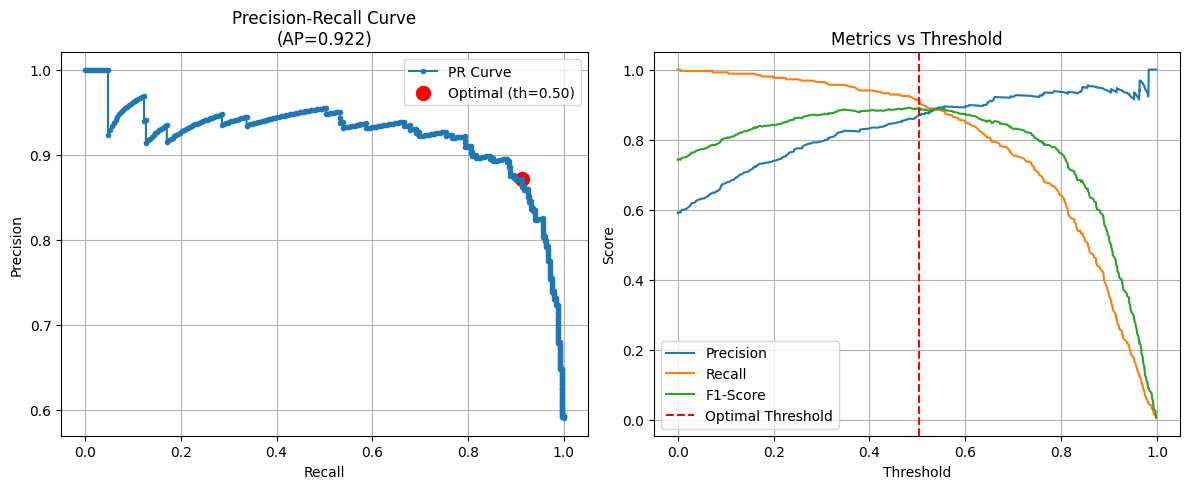

In [21]:
# Precision-Recall Curve with optimal threshold
# For imbalanced data, PR curve is more informative than ROC curve
precision_vals, recall_vals, thresholds = precision_recall_curve(y_val, y_proba_final)

# Find threshold that maximizes F1 score
# F1 is harmonic mean of precision and recall
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5

print(f"\nOptimal threshold (max F1): {optimal_threshold:.3f}")
print(f"Recall at optimal threshold: {recall_vals[optimal_idx]:.3f}")
print(f"Precision at optimal threshold: {precision_vals[optimal_idx]:.3f}")
print(f"F1 at optimal threshold: {f1_scores[optimal_idx]:.3f}")

# Visualizations
plt.figure(figsize=(12, 5))

# Plot 1: Precision-Recall Curve
plt.subplot(1, 2, 1)
plt.plot(recall_vals, precision_vals, marker='.', label='PR Curve')
plt.scatter(recall_vals[optimal_idx], precision_vals[optimal_idx], 
            color='red', s=100, label=f'Optimal (th={optimal_threshold:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve\n(AP={average_precision_score(y_val, y_proba_final):.3f})')
plt.legend()
plt.grid(True)

# Plot 2: Threshold vs Metrics
# Shows how metrics change with different thresholds
plt.subplot(1, 2, 2)
plt.plot(thresholds, precision_vals[:-1], label='Precision')
plt.plot(thresholds, recall_vals[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1-Score')
plt.axvline(optimal_threshold, color='red', linestyle='--', label='Optimal Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs Threshold')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
print("\n" + "="*80)
print("FINAL MODEL SELECTION")
print("="*80)

# Compile all final results (adjust according to models tested)
final_comparison = pd.DataFrame([
    rf_metrics,
    xgb_metrics,
    lgbm_metrics,
    best_xgb_metrics,  # GridSearch
    optuna_metrics     # Optuna
])

print(final_comparison.to_string(index=False))

# Selection criteria
print("\n" + "="*80)
print("SELECTION CRITERIA")
print("="*80)
print("1. Minimum recall: 0.85 (business requirement)")
print("2. Tie-breaker: PR-AUC (balanced metric for recall/precision)")
print("3. Simplicity: prefer fewer hyperparameters if performance is similar")

# Filter models that meet minimum recall requirement
qualified_models = final_comparison[final_comparison['Recall'] >= 0.85]

# Log model comparison to MLflow
with mlflow.start_run(run_name="Model_Comparison"):
    
    # Log all model metrics for comparison
    for idx, row in final_comparison.iterrows():
        model_name = row['Model'].replace(' ', '_').replace('(', '').replace(')', '')
        mlflow.log_metric(f"{model_name}_recall", row['Recall'])
        mlflow.log_metric(f"{model_name}_precision", row['Precision'])
        mlflow.log_metric(f"{model_name}_f1", row['F1'])
        mlflow.log_metric(f"{model_name}_roc_auc", row['ROC-AUC'])
        mlflow.log_metric(f"{model_name}_pr_auc", row['PR-AUC'])
    
    # Save comparison table
    comparison_path = "model_comparison.csv"
    final_comparison.to_csv(comparison_path, index=False)
    mlflow.log_artifact(comparison_path)
    
    # Log selection criteria
    mlflow.log_param("min_recall_requirement", 0.85)
    mlflow.log_param("tiebreaker_metric", "PR-AUC")
    mlflow.log_metric("n_qualified_models", len(qualified_models))

if len(qualified_models) > 0:
    print(f"\nQualified models (recall >= 0.85): {len(qualified_models)}")
    print(qualified_models[['Model', 'Recall', 'Precision', 'PR-AUC']].to_string(index=False))
    
    # Select best PR-AUC among qualified models
    best_idx = qualified_models['PR-AUC'].idxmax()
    selected_model_name = qualified_models.loc[best_idx, 'Model']
    
    print("\n" + "="*80)
    print(f"SELECTED MODEL: {selected_model_name}")
    print("="*80)
    
    # Get final hyperparameters
    if 'Optuna' in selected_model_name:
        final_model = xgb_optuna
        final_params = best_params_optuna
    elif 'Tuned' in selected_model_name:
        final_model = best_xgb
        final_params = grid_search_xgb.best_params_
    else:
        # Default model
        final_model = xgb_model
        final_params = xgb_model.get_params()
    
    # Log final selection
    with mlflow.start_run(run_name="Final_Model_Selection"):
        mlflow.log_param("selected_model", selected_model_name)
        mlflow.log_params(final_params)
        
        for k, v in qualified_models.loc[best_idx].items():
            if k != 'Model':
                mlflow.log_metric(f"final_{k.lower().replace('-', '_')}", v)
        
        # Log justification as text
        justification = f"""
        Selected Model: {selected_model_name}
        
        Justification:
        - Meets recall requirement >= 0.85: {qualified_models.loc[best_idx, 'Recall']:.3f}
        - Best PR-AUC among qualified models: {qualified_models.loc[best_idx, 'PR-AUC']:.3f}
        - Acceptable precision: {qualified_models.loc[best_idx, 'Precision']:.3f}
        """
        
        justification_path = "model_selection_justification.txt"
        with open(justification_path, 'w') as f:
            f.write(justification)
        mlflow.log_artifact(justification_path)
    
    print("\nFINAL HYPERPARAMETERS:")
    for k, v in final_params.items():
        print(f"  {k}: {v}")
    
    print("\nEXPECTED METRICS (Validation Set):")
    for k, v in qualified_models.loc[best_idx].items():
        if k != 'Model':
            print(f"  {k}: {v:.3f}")
    
    print("\nJUSTIFICATION:")
    print(f"  - Meets recall requirement >= 0.85: {qualified_models.loc[best_idx, 'Recall']:.3f}")
    print(f"  - Best PR-AUC among qualified models: {qualified_models.loc[best_idx, 'PR-AUC']:.3f}")
    print(f"  - Acceptable precision: {qualified_models.loc[best_idx, 'Precision']:.3f}")
    
else:
    print("\nNO MODEL achieved recall >= 0.85")
    
    # Log failure to MLflow
    with mlflow.start_run(run_name="Model_Selection_Failed"):
        mlflow.log_param("selection_status", "FAILED")
        mlflow.log_param("reason", "No model achieved minimum recall requirement")
        mlflow.log_metric("max_recall_achieved", final_comparison['Recall'].max())
    
    print("Recommendations:")
    print("  1. Review feature engineering")
    print("  2. Expand hyperparameter search space")
    print("  3. Consider balancing techniques (SMOTE, undersampling)")
    print("  4. Manually adjust threshold to prioritize recall")


FINAL MODEL SELECTION
           Model   Recall  Precision       F1  ROC-AUC   PR-AUC
    RandomForest 0.817460   0.673203 0.738351 0.678367 0.738965
         XGBoost 0.813492   0.762082 0.786948 0.789320 0.825912
        LightGBM 0.789683   0.742537 0.765385 0.778209 0.818560
 XGBoost (Tuned) 0.825397   0.796935 0.810916 0.844104 0.867952
XGBoost (Optuna) 0.912698   0.867925 0.889749 0.916417 0.922227

SELECTION CRITERIA
1. Minimum recall: 0.85 (business requirement)
2. Tie-breaker: PR-AUC (balanced metric for recall/precision)
3. Simplicity: prefer fewer hyperparameters if performance is similar
🏃 View run Model_Comparison at: http://localhost:5000/#/experiments/2/runs/480628bfbb5043ee84bb6228bdf05e0b
🧪 View experiment at: http://localhost:5000/#/experiments/2

Qualified models (recall >= 0.85): 1
           Model   Recall  Precision   PR-AUC
XGBoost (Optuna) 0.912698   0.867925 0.922227

SELECTED MODEL: XGBoost (Optuna)
🏃 View run Final_Model_Selection at: http://localhost:5000/#/e


FINAL EVALUATION - TEST SET


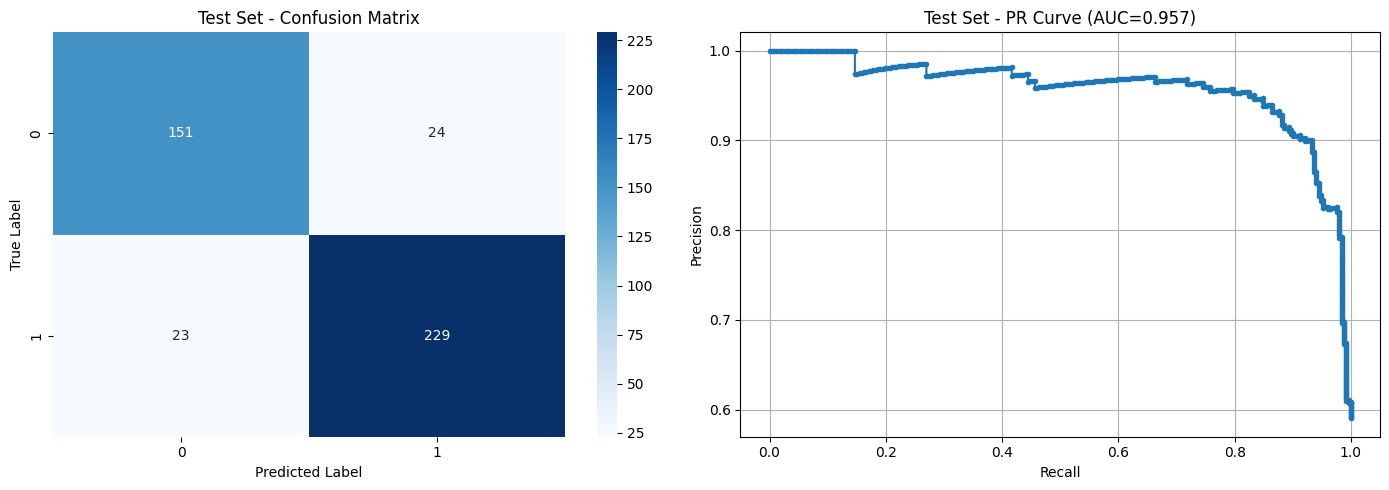

2026/02/12 22:18:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Test Set Metrics:
  Recall: 0.909
  Precision: 0.905
  F1: 0.907
  ROC-AUC: 0.946
  PR-AUC: 0.957

Confusion Matrix (Test Set):
[[151  24]
 [ 23 229]]

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.87      0.86      0.87       175
           1       0.91      0.91      0.91       252

    accuracy                           0.89       427
   macro avg       0.89      0.89      0.89       427
weighted avg       0.89      0.89      0.89       427

🏃 View run Final_Test_Evaluation at: http://localhost:5000/#/experiments/2/runs/8b5b52b8e0e54b3890f44196bb874d89
🧪 View experiment at: http://localhost:5000/#/experiments/2


In [23]:
print("\n" + "="*80)
print("FINAL EVALUATION - TEST SET")
print("="*80)

# Create final evaluation run in MLflow
with mlflow.start_run(run_name="Final_Test_Evaluation"):
    
    # Log model information
    mlflow.log_param("evaluated_model", selected_model_name)
    mlflow.log_params(final_params)
    
    # Predictions on test set (never seen before)
    # This gives unbiased estimate of model performance
    y_test_pred = final_model.predict(X_test)
    y_test_proba = final_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    test_metrics = {
        'Recall': recall_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred),
        'F1': f1_score(y_test, y_test_pred),
        'ROC-AUC': roc_auc_score(y_test, y_test_proba),
        'PR-AUC': average_precision_score(y_test, y_test_proba)
    }
    
    # Log test metrics
    mlflow.log_metric("test_recall", test_metrics['Recall'])
    mlflow.log_metric("test_precision", test_metrics['Precision'])
    mlflow.log_metric("test_f1", test_metrics['F1'])
    mlflow.log_metric("test_roc_auc", test_metrics['ROC-AUC'])
    mlflow.log_metric("test_pr_auc", test_metrics['PR-AUC'])
    
    # Confusion matrix
    cm_test = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm_test.ravel()
    mlflow.log_metric("test_true_negatives", int(tn))
    mlflow.log_metric("test_false_positives", int(fp))
    mlflow.log_metric("test_false_negatives", int(fn))
    mlflow.log_metric("test_true_positives", int(tp))
    
    # Log classification report
    import json
    report = classification_report(y_test, y_test_pred, output_dict=True)
    report_path = "test_classification_report.json"
    with open(report_path, 'w') as f:
        json.dump(report, f, indent=2)
    mlflow.log_artifact(report_path)
    
    # Visualizations
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Confusion Matrix
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Test Set - Confusion Matrix')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
    
    # Plot 2: Precision-Recall Curve
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)
    axes[1].plot(recall_test, precision_test, marker='.')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title(f'Test Set - PR Curve (AUC={test_metrics["PR-AUC"]:.3f})')
    axes[1].grid(True)
    
    plt.tight_layout()
    
    # Save and log figure
    fig_path = "test_evaluation_plots.png"
    plt.savefig(fig_path)
    mlflow.log_artifact(fig_path)
    plt.show()
    
    # Log final model
    if 'XGBoost' in selected_model_name:
        mlflow.xgboost.log_model(final_model, "final_model")
    elif 'LightGBM' in selected_model_name:
        mlflow.lightgbm.log_model(final_model, "final_model")
    else:
        mlflow.sklearn.log_model(final_model, "final_model")
    
    # Save test metrics
    metrics_path = "test_metrics.json"
    with open(metrics_path, 'w') as f:
        json.dump(test_metrics, f, indent=2)
    mlflow.log_artifact(metrics_path)
    
    print("Test Set Metrics:")
    for k, v in test_metrics.items():
        print(f"  {k}: {v:.3f}")
    
    print("\nConfusion Matrix (Test Set):")
    print(cm_test)
    
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))

In [24]:
import joblib
from datetime import datetime

# Save final model with MLflow integration
with mlflow.start_run(run_name="Model_Artifacts_Save"):
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save model using joblib (for local backup)
    model_filename = f"best_model_{selected_model_name.replace(' ', '_')}_{timestamp}.pkl"
    joblib.dump(final_model, model_filename)
    mlflow.log_artifact(model_filename)
    print(f"\nModel saved locally and to MLflow: {model_filename}")
    
    # Save hyperparameters
    import json
    params_filename = f"best_params_{timestamp}.json"
    with open(params_filename, 'w') as f:
        serializable_params = {k: str(v) if not isinstance(v, (int, float, str, bool, type(None))) else v 
                              for k, v in final_params.items()}
        json.dump(serializable_params, f, indent=2)
    mlflow.log_artifact(params_filename)
    print(f"Hyperparameters saved: {params_filename}")
    
    # Save test metrics
    metrics_filename = f"test_metrics_{timestamp}.json"
    with open(metrics_filename, 'w') as f:
        json.dump(test_metrics, f, indent=2)
    mlflow.log_artifact(metrics_filename)
    print(f"Test metrics saved: {metrics_filename}")
    
    # Log metadata
    mlflow.log_param("model_save_timestamp", timestamp)
    mlflow.log_param("model_filename", model_filename)
    mlflow.log_param("artifacts_saved", "model, params, metrics")
    
    # Create model card
    model_card = f"""
    # Model Card: {selected_model_name}
    
    ## Model Information
    - Model Type: {selected_model_name}
    - Training Date: {timestamp}
    - Random State: {RANDOM_STATE}
    
    ## Dataset
    - Total Samples: {len(df)}
    - Training Samples: {len(X_train)}
    - Validation Samples: {len(X_val)}
    - Test Samples: {len(X_test)}
    - Features: {', '.join(X.columns.tolist())}
    - Target: defasagem (binary: 0/1)
    - Class Imbalance Ratio: {(y == 0).sum() / (y == 1).sum():.2f}
    
    ## Performance Metrics (Test Set)
    - Recall: {test_metrics['Recall']:.3f}
    - Precision: {test_metrics['Precision']:.3f}
    - F1-Score: {test_metrics['F1']:.3f}
    - ROC-AUC: {test_metrics['ROC-AUC']:.3f}
    - PR-AUC: {test_metrics['PR-AUC']:.3f}
    
    ## Hyperparameters
    {json.dumps(serializable_params, indent=2)}
    
    ## Usage
```python
    import joblib
    model = joblib.load('{model_filename}')
    predictions = model.predict(X)
    probabilities = model.predict_proba(X)[:, 1]
```
    
    ## Notes
    - Model optimized for recall (minimum 0.85 requirement)
    - Suitable for imbalanced classification problems
    - Consider recalibration if probability estimates are critical
    """
    
    model_card_path = f"model_card_{timestamp}.md"
    with open(model_card_path, 'w') as f:
        f.write(model_card)
    mlflow.log_artifact(model_card_path)
    print(f"Model card saved: {model_card_path}")
    
    print("\nAll artifacts saved to MLflow!")


Model saved locally and to MLflow: best_model_XGBoost_(Optuna)_20260212_221804.pkl
Hyperparameters saved: best_params_20260212_221804.json
Test metrics saved: test_metrics_20260212_221804.json
Model card saved: model_card_20260212_221804.md

All artifacts saved to MLflow!
🏃 View run Model_Artifacts_Save at: http://localhost:5000/#/experiments/2/runs/d7a29a71a32a486886854cc359161d16
🧪 View experiment at: http://localhost:5000/#/experiments/2


In [25]:
# Compare all runs from the experiment programmatically
from mlflow.tracking import MlflowClient

client = MlflowClient()

# Get experiment by name
experiment = client.get_experiment_by_name(EXPERIMENT_NAME)

if experiment:
    # Get all runs from the experiment
    runs = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        order_by=["metrics.recall DESC"]  # Order by recall
    )
    
    print("\n" + "="*80)
    print(f"ALL RUNS IN EXPERIMENT: {EXPERIMENT_NAME}")
    print("="*80)
    print(f"Total runs: {len(runs)}")
    
    # Create comparison dataframe
    comparison_data = []
    for run in runs:
        run_data = {
            'run_id': run.info.run_id,
            'run_name': run.data.tags.get('mlflow.runName', 'N/A'),
            'recall': run.data.metrics.get('recall', None),
            'precision': run.data.metrics.get('precision', None),
            'f1': run.data.metrics.get('f1', None),
            'pr_auc': run.data.metrics.get('pr_auc', None),
            'status': run.info.status
        }
        comparison_data.append(run_data)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Filter only finished runs with metrics
    comparison_df = comparison_df[comparison_df['recall'].notna()]
    
    print("\nTop 10 runs by Recall:")
    print(comparison_df.head(10).to_string(index=False))
    
    # Save comparison
    comparison_path = "mlflow_runs_comparison.csv"
    comparison_df.to_csv(comparison_path, index=False)
    print(f"\nFull comparison saved to: {comparison_path}")
else:
    print(f"Experiment '{EXPERIMENT_NAME}' not found!")


ALL RUNS IN EXPERIMENT: defasagem_prediction
Total runs: 23

Top 10 runs by Recall:
                          run_id                 run_name   recall  precision       f1   pr_auc   status
81b2fc3f79ce4b35be00dbe483d35bc1 XGBoost_Tuned_Validation 0.825397   0.796935 0.810916 0.867952 FINISHED
01a3b2edc4bc4a1badce025f6a3a7250 XGBoost_Tuned_Validation 0.825397   0.796935 0.810916 0.867952 FINISHED
ef66419442f74598b04d4e790099bd6e             RandomForest 0.817460   0.673203 0.738351 0.738965 FINISHED
52d25e751920440a84ddd1564c5e7354             RandomForest 0.817460   0.673203 0.738351 0.738965 FINISHED
ebe05c9687074bae82e6200ce3a1c9a4                  XGBoost 0.813492   0.762082 0.786948 0.825912 FINISHED
1387e47260e94b9da08b13f642ff8ed8                  XGBoost 0.813492   0.762082 0.786948 0.825912 FINISHED
ed77c8cc67d64f3291e84c3907e7a056                 LightGBM 0.789683   0.742537 0.765385 0.818560 FINISHED
6c976393b99b48adb3e7ae1c3601fd16                 LightGBM 0.789683   0.7425